In [ ]:
!pip install tqdm

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 10.0 MB/s eta 0:00:00


In [117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm
import torch, torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import os
import shutil

# Задание 1

1.1  Сгенерируйте данные, повторяющие распределение на классы:
d = 2 (число признаков)
N_train = 1000
N_val = 100


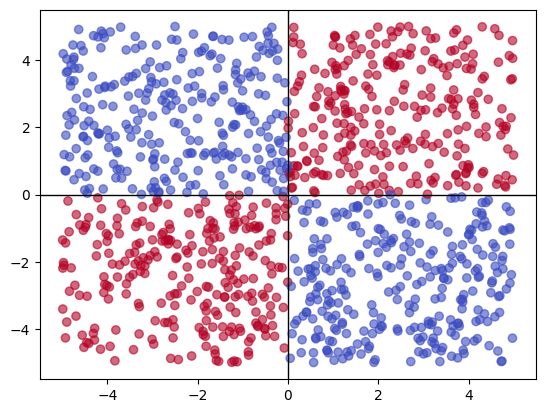

In [81]:
def generate_first_data(N, d):
  X = np.random.uniform(-5, 5, (N, d))
  y = ((X[:, 0] * X[:, 1]) > 0 ).astype(int)
  return X, y

X, y = generate_first_data(1100, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)


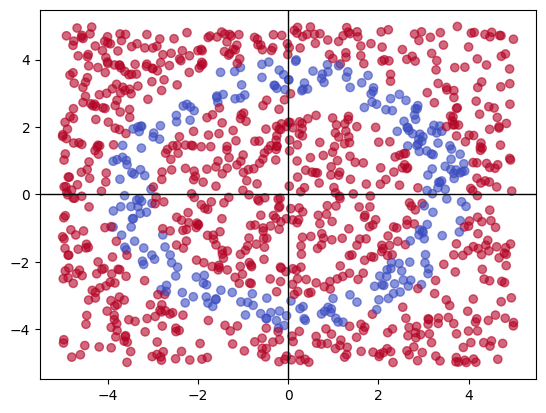

In [82]:
def generate_second_data(N, d):
  X = np.random.uniform(-5, 5, (N, d))
  dist = np.linalg.norm(X, axis=1)
  rad_1 = 3
  rad_2 = 4
  y = ((dist >= rad_2) | (dist <= rad_1)).astype(int)
  return X, y

X, y = generate_second_data(1100, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)

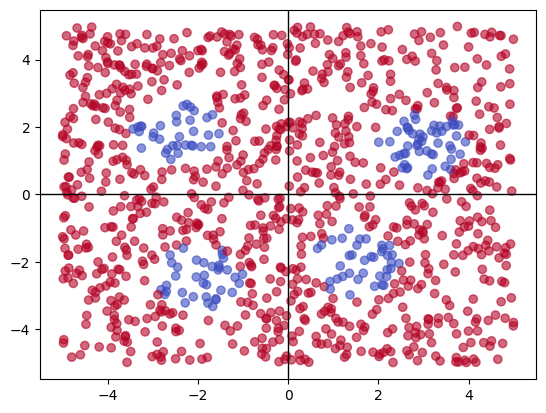

In [83]:
def generate_third_data(N, d):
  centers = [(-2.5, 2),  (-2, -2.5),   (1.5, -2),  (3, 1.5)]
  radius = 1
  dist = np.array([np.linalg.norm(X - np.array(c), axis=1) for c in centers])
  min_dist = np.min(dist, axis=0)
  y = (min_dist >= radius).astype(int)
  return X, y

X, y = generate_third_data(1100, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.6)
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)

1.2 Используя полученные данные, реализуйте на torch и натренируйте до сходимости линейную модель (МЛП без скрытых слоев) используя AdamW оптимизатор с дефолтными параметрами и batch_size=64. После каждой итерации проводите замеры на валидационных данных и визуализируйте предсказания модели.


Напишем класс для создания датасета, а также создадим dataloader

In [84]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

Напишем функцию train_model

In [85]:
def plot_boundaries(model, X, target, title="Predicted boundaries", save_path=None):

    plt.figure(figsize=(6, 5))

    h = 1
    X = X.cpu().numpy()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    model.eval()
    with torch.no_grad():
         logits = model(grid)
         probs = torch.sigmoid(logits).squeeze()
         predicted_grid = (probs > 0.5).cpu().numpy()

    predicted_grid = predicted_grid.reshape(xx.shape)
    plt.contourf(xx, yy, predicted_grid, alpha=0.3, levels=[-0.5, 0.5, 1.5], colors=['blue', 'red'])

    scatter = plt.scatter(X[:, 0], X[:, 1], c=target, cmap='bwr', edgecolor='k')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [86]:
#shutil.rmtree("/content/my_plots")

In [87]:
def train_model_binclf(model, train_loader, val_loader, epochs, hidden_layers=0, type_data=1):
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.AdamW(model.parameters(), lr=0.001)

  EPOCHS = epochs
  iteration = 0

  train_losses = [] #лоссы на тренировочных данных на каждой итерации
  val_losses = [] #лоссы на валидационных данных на каждой итерации
  acc_train_scores = [] #accuracy на тренировочных данных на каждой итерации
  acc_val_scores = [] #accuracy на валидационных данных на каждой итерации
  train_epoch_losses = [] # лоссы на тренировочных данных на каждой эпохе
  acc_val_epoch_scores = []  #accuracy на валидационных данных на каждой эпохе
  val_epoch_losses = [] # лоссы на валидационных данных на каждой эпохе
  acc_train_epoch_scores = [] #accuracy на тренировочных данных на каждой эпохе

  save_dir=f"/content/my_plots/MLP{hidden_layers}/data{type_data}"

  if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

  for epoch in tqdm(range(EPOCHS)):
      model.train()
      running_loss = 0.0
      running_accuracy = 0.0

      for batch_idx, (data, target) in enumerate(train_loader):
          iteration += 1
          optimizer.zero_grad()

          output = model(data)
          predicted = (output > 0.5).float()
          loss = criterion(output, target)
          acc_train_score = accuracy_score(target, predicted)
          acc_train_scores.append(acc_train_score)
          train_losses.append(loss.item())

          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          running_accuracy += acc_train_score

          model.eval()
          val_loss = 0.0
          acc_val_score = 0.0
          with torch.no_grad():
              all_data = torch.tensor([])
              all_labels = torch.tensor([])
              for data, target in test_loader:
                all_data = torch.cat([all_data, data])
                all_labels = torch.cat([all_labels, target])
                output = model(data)
                predicted = (output > 0.5).float()
                loss = criterion(output, target)
                val_loss += loss.item()
                acc_val_score += accuracy_score(target, predicted)

          val_loss /= len(test_loader) #лосс на валидационных данных на текущей итерации
          acc_val_score /= len(test_loader)
          val_losses.append(val_loss)
          acc_val_scores.append(acc_val_score)

          if iteration % 10 == 0:
            print(f"iteration {iteration}, train loss {train_losses[-1]:.4f}, val loss {val_loss:.4f}, train acc {acc_train_score:.4f}, val acc {acc_val_score:.4f}")

          save_path = os.path.join(save_dir, f"epoch_{epoch+1:02d}_batch_{batch_idx+1:03d}.png")
          plot_boundaries(model, all_data, all_labels, title=f"Epoch {epoch+1}, Batch {batch_idx+1}", save_path=save_path)

      epoch_loss = running_loss / len(train_loader)
      train_epoch_losses.append(epoch_loss)
      acc_train_epoch_scores.append(running_accuracy/len(train_loader))

      model.eval()
      val_epoch_loss = 0.0
      y_true = []
      y_pred = []
      with torch.no_grad():
           for data, target in test_loader:

               output = model(data)
               predicted = (output > 0.5).float()
               loss = criterion(output, target)
               val_epoch_loss += loss.item()
               acc_val_epoch_score = accuracy_score(target, predicted)
               y_true.extend(target.cpu().numpy())
               y_pred.extend(predicted.cpu().numpy())

      accuracy = accuracy_score(y_true, y_pred)
      acc_val_epoch_scores.append(accuracy)
      #print(accuracy)
      #acc_val_epoch_scores.append(acc_val_score)

      val_epoch_loss /= len(test_loader)
      val_epoch_losses.append(val_epoch_loss)


  plt.figure(figsize=(7, 3))
  plt.plot(train_epoch_losses, label='Train Loss')
  plt.plot(val_epoch_losses, label='Validation Loss')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.title('Обучение модели')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(7, 3))
  plt.plot(acc_train_epoch_scores, label='Train accuracy')
  plt.plot(acc_val_epoch_scores, label='Validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()


Напишем функцию evaluate_model

In [131]:
def evaluate_model_binclf(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in test_loader:

            outputs = model(data)
            predicted = (outputs > 0.5).float()

            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy на валидационных данных: {accuracy:.4f}")

Применим нашу модель к первому виду распределения данных

Примечание: визуализация предсказаний в виде изображений сохраняется в папку my_plots в колабе. На графиках отображены предсказания модели по сетке (фон) и реальные точки (таргеты), чтобы оценить, насколько хорошо модель разделяет классы.

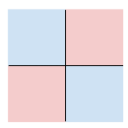

In [90]:
class MLPZero(nn.Module):
  def __init__(self):
    super(MLPZero, self).__init__()
    self.fc1 = nn.Linear(2, 1)

  def forward(self, x):
    x = self.fc1(x)
    return x.squeeze()

Разделим данные на обучающую (1000 объектов) и валидационную (100 объектов) выборки.

In [93]:
X, y = generate_first_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.8931, val loss 0.8840, train acc 0.4531, val acc 0.5087


  7%|▋         | 1/15 [00:03<00:48,  3.49s/it]

iteration 20, train loss 0.7649, val loss 0.8757, train acc 0.5469, val acc 0.5087
iteration 30, train loss 0.8098, val loss 0.8679, train acc 0.5156, val acc 0.5165


 13%|█▎        | 2/15 [00:07<00:48,  3.73s/it]

iteration 40, train loss 0.8469, val loss 0.8601, train acc 0.5156, val acc 0.5165


 20%|██        | 3/15 [00:11<00:49,  4.13s/it]

iteration 50, train loss 0.7841, val loss 0.8526, train acc 0.5156, val acc 0.5226
iteration 60, train loss 0.8939, val loss 0.8455, train acc 0.4531, val acc 0.5226


 27%|██▋       | 4/15 [00:15<00:41,  3.81s/it]

iteration 70, train loss 0.6747, val loss 0.8386, train acc 0.6406, val acc 0.5226
iteration 80, train loss 0.7196, val loss 0.8318, train acc 0.6000, val acc 0.5226


 33%|███▎      | 5/15 [00:18<00:36,  3.60s/it]

iteration 90, train loss 0.8116, val loss 0.8252, train acc 0.4844, val acc 0.5009


 40%|████      | 6/15 [00:23<00:35,  3.93s/it]

iteration 100, train loss 0.7276, val loss 0.8188, train acc 0.5781, val acc 0.4931
iteration 110, train loss 0.7337, val loss 0.8127, train acc 0.5469, val acc 0.4931


 47%|████▋     | 7/15 [00:26<00:29,  3.69s/it]

iteration 120, train loss 0.7180, val loss 0.8069, train acc 0.5625, val acc 0.4852


 53%|█████▎    | 8/15 [00:29<00:24,  3.51s/it]

iteration 130, train loss 0.7551, val loss 0.8012, train acc 0.5312, val acc 0.4913
iteration 140, train loss 0.6924, val loss 0.7960, train acc 0.5938, val acc 0.5052


 60%|██████    | 9/15 [00:33<00:21,  3.57s/it]

iteration 150, train loss 0.7180, val loss 0.7902, train acc 0.5781, val acc 0.5052


 67%|██████▋   | 10/15 [00:37<00:18,  3.71s/it]

iteration 160, train loss 0.6350, val loss 0.7850, train acc 0.6250, val acc 0.5269
iteration 170, train loss 0.7008, val loss 0.7805, train acc 0.6250, val acc 0.5269


 73%|███████▎  | 11/15 [00:40<00:14,  3.56s/it]

iteration 180, train loss 0.7008, val loss 0.7757, train acc 0.5781, val acc 0.5347
iteration 190, train loss 0.7233, val loss 0.7712, train acc 0.5312, val acc 0.5347


 80%|████████  | 12/15 [00:43<00:10,  3.44s/it]

iteration 200, train loss 0.7062, val loss 0.7671, train acc 0.5625, val acc 0.5486


 87%|████████▋ | 13/15 [00:47<00:07,  3.66s/it]

iteration 210, train loss 0.7557, val loss 0.7629, train acc 0.5156, val acc 0.5486
iteration 220, train loss 0.7325, val loss 0.7588, train acc 0.5156, val acc 0.5486


 93%|█████████▎| 14/15 [00:50<00:03,  3.54s/it]

iteration 230, train loss 0.6993, val loss 0.7548, train acc 0.6250, val acc 0.5564


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]

iteration 240, train loss 0.6654, val loss 0.7513, train acc 0.5750, val acc 0.5642


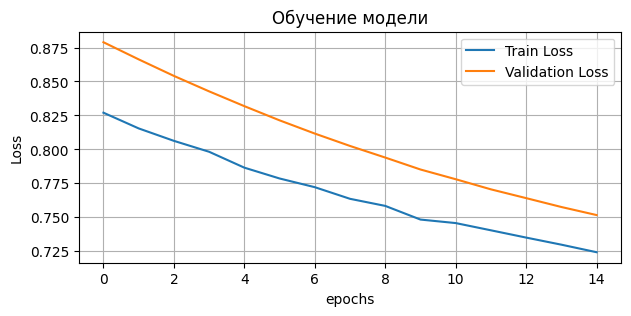

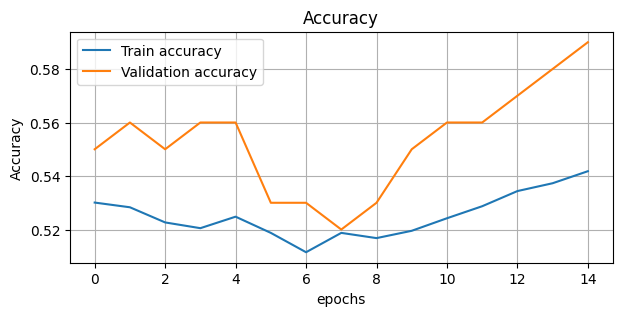

Accuracy на валидационных данных: 0.5900


In [94]:
model = MLPZero()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=0, type_data=1)
evaluate_model_binclf(model, test_loader)

Как видно по графику, MLP без скрытых слоев справляется с задачей не очень хорошо, accuracy на валидационных данных всего 0.6.

Применим модель ко второму набору данных

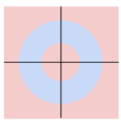

In [67]:
X, y = generate_second_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 1.0044, val loss 1.1719, train acc 0.3750, val acc 0.3342


  7%|▋         | 1/15 [00:03<00:44,  3.18s/it]

0.35
iteration 20, train loss 0.9962, val loss 1.1554, train acc 0.3750, val acc 0.3342
iteration 30, train loss 0.8817, val loss 1.1393, train acc 0.4844, val acc 0.3342


 13%|█▎        | 2/15 [00:07<00:46,  3.58s/it]

0.35
iteration 40, train loss 1.0464, val loss 1.1238, train acc 0.3750, val acc 0.3342


 20%|██        | 3/15 [00:10<00:41,  3.45s/it]

0.35
iteration 50, train loss 0.9175, val loss 1.1083, train acc 0.4375, val acc 0.3342
iteration 60, train loss 0.8980, val loss 1.0926, train acc 0.4219, val acc 0.3342


 27%|██▋       | 4/15 [00:13<00:36,  3.33s/it]

0.35
iteration 70, train loss 0.8063, val loss 1.0773, train acc 0.5312, val acc 0.3203
iteration 80, train loss 1.0060, val loss 1.0625, train acc 0.3500, val acc 0.3203


 33%|███▎      | 5/15 [00:18<00:37,  3.76s/it]

0.34
iteration 90, train loss 0.7694, val loss 1.0473, train acc 0.4688, val acc 0.3203


 40%|████      | 6/15 [00:21<00:34,  3.82s/it]

0.34
iteration 100, train loss 1.0549, val loss 1.0326, train acc 0.3906, val acc 0.3203
iteration 110, train loss 0.8577, val loss 1.0181, train acc 0.4844, val acc 0.3203


 47%|████▋     | 7/15 [00:25<00:28,  3.61s/it]

0.34
iteration 120, train loss 0.9513, val loss 1.0041, train acc 0.4375, val acc 0.3203


 53%|█████▎    | 8/15 [00:28<00:25,  3.59s/it]

0.34
iteration 130, train loss 0.9003, val loss 0.9901, train acc 0.4062, val acc 0.3203
iteration 140, train loss 0.8118, val loss 0.9761, train acc 0.4844, val acc 0.3203


 60%|██████    | 9/15 [00:32<00:22,  3.71s/it]

0.33
iteration 150, train loss 0.7244, val loss 0.9627, train acc 0.4531, val acc 0.3064
iteration 160, train loss 0.8694, val loss 0.9499, train acc 0.3750, val acc 0.3064


 67%|██████▋   | 10/15 [00:36<00:18,  3.74s/it]

0.33
iteration 170, train loss 0.7595, val loss 0.9374, train acc 0.4531, val acc 0.3064


 73%|███████▎  | 11/15 [00:41<00:16,  4.23s/it]

0.33
iteration 180, train loss 0.7076, val loss 0.9244, train acc 0.5156, val acc 0.3064
iteration 190, train loss 0.7723, val loss 0.9122, train acc 0.4219, val acc 0.3064


 80%|████████  | 12/15 [00:46<00:12,  4.33s/it]

0.33
iteration 200, train loss 0.8302, val loss 0.8995, train acc 0.3281, val acc 0.3064


 87%|████████▋ | 13/15 [00:49<00:07,  3.97s/it]

0.33
iteration 210, train loss 0.7753, val loss 0.8877, train acc 0.4219, val acc 0.3064
iteration 220, train loss 0.7195, val loss 0.8762, train acc 0.4531, val acc 0.3064


 93%|█████████▎| 14/15 [00:52<00:03,  3.74s/it]

0.33
iteration 230, train loss 0.7781, val loss 0.8652, train acc 0.4219, val acc 0.3064
iteration 240, train loss 0.6798, val loss 0.8543, train acc 0.5250, val acc 0.3064


100%|██████████| 15/15 [00:55<00:00,  3.73s/it]

0.33


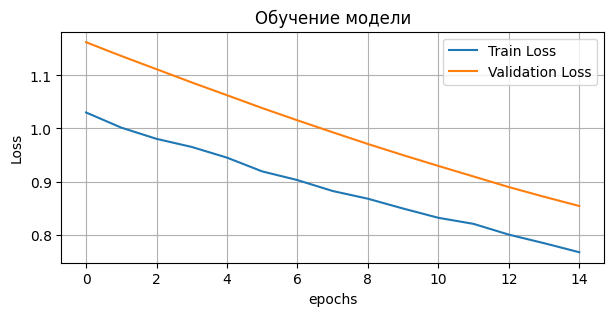

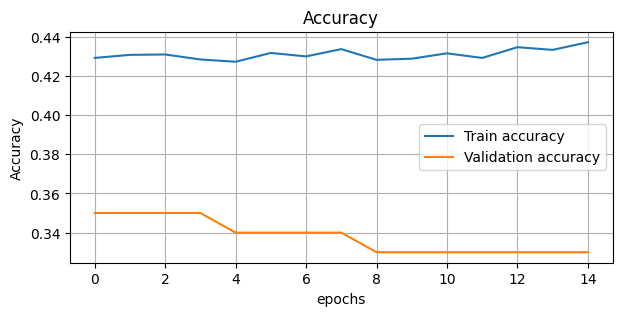

Accuracy на валидационных данных: 0.3300


In [68]:
model = MLPZero()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=0, type_data=2)
evaluate_model_binclf(model, test_loader)

На втором наборе данных модель работает плохо, accuracy очень низкая. Также на валидационных данных наблюдается небольшой спад accuracy c ростом количества эпох.

Применим модель к третьему набору данных

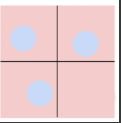

In [69]:
X, y = generate_third_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.7389, val loss 0.8237, train acc 0.5000, val acc 0.4688


  7%|▋         | 1/15 [00:03<00:43,  3.14s/it]

0.46
iteration 20, train loss 0.8404, val loss 0.8103, train acc 0.4844, val acc 0.4688
iteration 30, train loss 0.6919, val loss 0.7970, train acc 0.5000, val acc 0.4826


 13%|█▎        | 2/15 [00:07<00:50,  3.87s/it]

0.47
iteration 40, train loss 0.7234, val loss 0.7846, train acc 0.5156, val acc 0.4826


 20%|██        | 3/15 [00:11<00:48,  4.00s/it]

0.47
iteration 50, train loss 0.7793, val loss 0.7722, train acc 0.5156, val acc 0.4826
iteration 60, train loss 0.7639, val loss 0.7602, train acc 0.5000, val acc 0.4826


 27%|██▋       | 4/15 [00:14<00:40,  3.67s/it]

0.47
iteration 70, train loss 0.6350, val loss 0.7482, train acc 0.6094, val acc 0.4826


 33%|███▎      | 5/15 [00:18<00:35,  3.59s/it]

iteration 80, train loss 0.6571, val loss 0.7365, train acc 0.5500, val acc 0.4826
0.47
iteration 90, train loss 0.7739, val loss 0.7252, train acc 0.4062, val acc 0.4826


 40%|████      | 6/15 [00:21<00:31,  3.45s/it]

0.47
iteration 100, train loss 0.7909, val loss 0.7138, train acc 0.4844, val acc 0.4826
iteration 110, train loss 0.6645, val loss 0.7028, train acc 0.4844, val acc 0.4826


 47%|████▋     | 7/15 [00:25<00:29,  3.66s/it]

0.47
iteration 120, train loss 0.6610, val loss 0.6921, train acc 0.5469, val acc 0.4826


 53%|█████▎    | 8/15 [00:29<00:25,  3.63s/it]

0.47
iteration 130, train loss 0.6909, val loss 0.6820, train acc 0.4531, val acc 0.4826
iteration 140, train loss 0.6955, val loss 0.6727, train acc 0.4844, val acc 0.4826


 60%|██████    | 9/15 [00:32<00:20,  3.48s/it]

0.46
iteration 150, train loss 0.5828, val loss 0.6627, train acc 0.5781, val acc 0.4748
iteration 160, train loss 0.7181, val loss 0.6533, train acc 0.5000, val acc 0.4670


 67%|██████▋   | 10/15 [00:35<00:17,  3.53s/it]

0.45
iteration 170, train loss 0.5983, val loss 0.6439, train acc 0.5156, val acc 0.4592


 73%|███████▎  | 11/15 [00:39<00:14,  3.56s/it]

0.44
iteration 180, train loss 0.6312, val loss 0.6352, train acc 0.4688, val acc 0.4670
iteration 190, train loss 0.6677, val loss 0.6272, train acc 0.4219, val acc 0.4670


 80%|████████  | 12/15 [00:43<00:10,  3.59s/it]

0.45
iteration 200, train loss 0.5988, val loss 0.6187, train acc 0.5781, val acc 0.4670


 87%|████████▋ | 13/15 [00:46<00:06,  3.46s/it]

0.46
iteration 210, train loss 0.6100, val loss 0.6107, train acc 0.5625, val acc 0.4887
iteration 220, train loss 0.6448, val loss 0.6027, train acc 0.4375, val acc 0.4887


 93%|█████████▎| 14/15 [00:50<00:03,  3.64s/it]

0.48
iteration 230, train loss 0.6297, val loss 0.5953, train acc 0.5156, val acc 0.4965
iteration 240, train loss 0.5409, val loss 0.5884, train acc 0.5500, val acc 0.4965


100%|██████████| 15/15 [00:53<00:00,  3.57s/it]

0.48


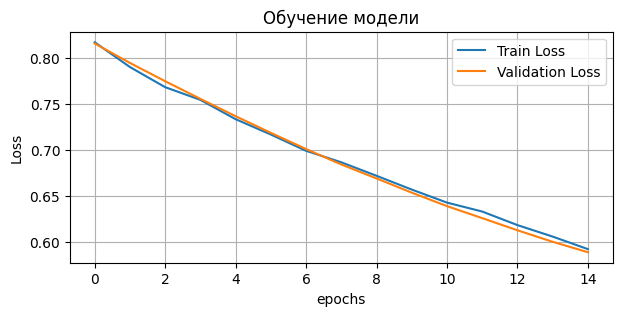

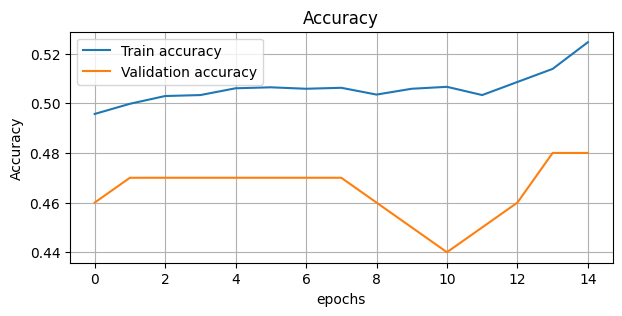

Accuracy на валидационных данных: 0.4800


In [70]:
model = MLPZero()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=0, type_data=3)
evaluate_model_binclf(model, test_loader)

На 3 наборе данных accuracy тоже низкая, модель плохо различает классы.

Теперь добавим один скрытый слой в MLP

In [71]:
class MLPOne(nn.Module):
  def __init__(self):
    super(MLPOne, self).__init__()
    self.fc1 = nn.Linear(2, 8)
    self.ac1 = nn.ReLU()
    self.fc2 = nn.Linear(8, 1)
    #self.ac2 = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    #x = self.ac2(x)
    return x.squeeze(1)

Повторим эксперимент для первого набора данных

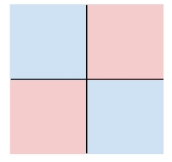

In [97]:
X, y = generate_first_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.7213, val loss 0.7411, train acc 0.2969, val acc 0.3012


  7%|▋         | 1/15 [00:04<01:03,  4.55s/it]

iteration 20, train loss 0.7328, val loss 0.7257, train acc 0.2969, val acc 0.3646
iteration 30, train loss 0.7261, val loss 0.7118, train acc 0.3594, val acc 0.3724


 13%|█▎        | 2/15 [00:08<00:56,  4.32s/it]

iteration 40, train loss 0.7256, val loss 0.6989, train acc 0.3906, val acc 0.3863


 20%|██        | 3/15 [00:12<00:46,  3.90s/it]

iteration 50, train loss 0.6792, val loss 0.6875, train acc 0.5000, val acc 0.4297
iteration 60, train loss 0.6198, val loss 0.6775, train acc 0.4688, val acc 0.4792


 27%|██▋       | 4/15 [00:15<00:39,  3.61s/it]

iteration 70, train loss 0.6695, val loss 0.6682, train acc 0.4531, val acc 0.5165
iteration 80, train loss 0.6603, val loss 0.6600, train acc 0.5500, val acc 0.5521


 33%|███▎      | 5/15 [00:18<00:35,  3.58s/it]

iteration 90, train loss 0.6601, val loss 0.6523, train acc 0.6250, val acc 0.5738


 40%|████      | 6/15 [00:22<00:32,  3.63s/it]

iteration 100, train loss 0.6212, val loss 0.6453, train acc 0.5312, val acc 0.6050
iteration 110, train loss 0.6439, val loss 0.6386, train acc 0.5469, val acc 0.6128


 47%|████▋     | 7/15 [00:26<00:28,  3.61s/it]

iteration 120, train loss 0.6501, val loss 0.6322, train acc 0.6406, val acc 0.6267


 53%|█████▎    | 8/15 [00:29<00:24,  3.47s/it]

iteration 130, train loss 0.6023, val loss 0.6258, train acc 0.6562, val acc 0.6267
iteration 140, train loss 0.6521, val loss 0.6195, train acc 0.5938, val acc 0.6267


 60%|██████    | 9/15 [00:33<00:21,  3.65s/it]

iteration 150, train loss 0.6026, val loss 0.6134, train acc 0.6719, val acc 0.6207


 67%|██████▋   | 10/15 [00:36<00:18,  3.66s/it]

iteration 160, train loss 0.6406, val loss 0.6074, train acc 0.7000, val acc 0.6068
iteration 170, train loss 0.5661, val loss 0.6014, train acc 0.6875, val acc 0.6363


 73%|███████▎  | 11/15 [00:40<00:14,  3.52s/it]

iteration 180, train loss 0.6123, val loss 0.5956, train acc 0.7500, val acc 0.6363
iteration 190, train loss 0.5853, val loss 0.5898, train acc 0.5469, val acc 0.6363


 80%|████████  | 12/15 [00:43<00:10,  3.42s/it]

iteration 200, train loss 0.6085, val loss 0.5840, train acc 0.7344, val acc 0.6441


 87%|████████▋ | 13/15 [00:47<00:07,  3.62s/it]

iteration 210, train loss 0.5491, val loss 0.5785, train acc 0.7188, val acc 0.6675
iteration 220, train loss 0.5230, val loss 0.5731, train acc 0.6094, val acc 0.6675


 93%|█████████▎| 14/15 [00:50<00:03,  3.47s/it]

iteration 230, train loss 0.5838, val loss 0.5678, train acc 0.5625, val acc 0.6814


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]

iteration 240, train loss 0.5330, val loss 0.5627, train acc 0.7750, val acc 0.6892


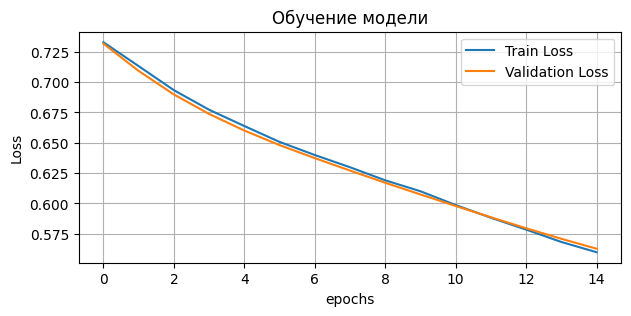

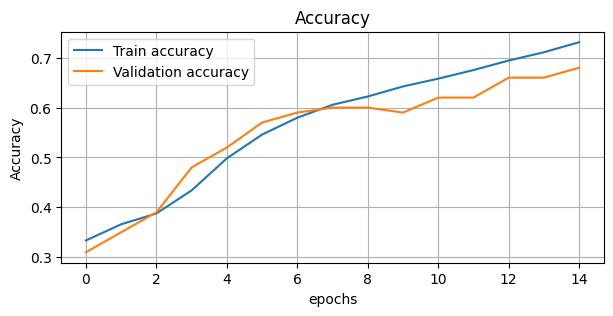

Accuracy на валидационных данных: 0.6800


In [98]:
model = MLPOne()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=1, type_data=1)
evaluate_model_binclf(model, test_loader)

По сравнению с MLP без скрытых слоев, качество модели повысилось. В первом случае accuracy ниже (0.6), чем в этом (0.68). Accuracy растет с количеством эпох, а loss уменьшается.

Повторим эксперимент на втором наборе данных

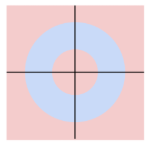

In [99]:
X, y = generate_second_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.6270, val loss 0.6076, train acc 0.4062, val acc 0.4661


  7%|▋         | 1/15 [00:03<00:43,  3.10s/it]

iteration 20, train loss 0.6370, val loss 0.5921, train acc 0.4375, val acc 0.5174
iteration 30, train loss 0.5866, val loss 0.5785, train acc 0.4531, val acc 0.5095


 13%|█▎        | 2/15 [00:07<00:47,  3.64s/it]

iteration 40, train loss 0.6418, val loss 0.5663, train acc 0.4375, val acc 0.5174


 20%|██        | 3/15 [00:10<00:41,  3.45s/it]

iteration 50, train loss 0.6318, val loss 0.5556, train acc 0.3906, val acc 0.5156
iteration 60, train loss 0.5234, val loss 0.5466, train acc 0.5625, val acc 0.5356


 27%|██▋       | 4/15 [00:13<00:36,  3.33s/it]

iteration 70, train loss 0.5431, val loss 0.5382, train acc 0.5000, val acc 0.5868


 33%|███▎      | 5/15 [00:16<00:32,  3.24s/it]

iteration 80, train loss 0.5150, val loss 0.5306, train acc 0.5500, val acc 0.6163
iteration 90, train loss 0.5774, val loss 0.5243, train acc 0.5312, val acc 0.6241


 40%|████      | 6/15 [00:21<00:35,  3.90s/it]

iteration 100, train loss 0.5610, val loss 0.5191, train acc 0.6562, val acc 0.6085
iteration 110, train loss 0.5730, val loss 0.5147, train acc 0.5469, val acc 0.6302


 47%|████▋     | 7/15 [00:24<00:29,  3.66s/it]

iteration 120, train loss 0.5634, val loss 0.5105, train acc 0.5938, val acc 0.6458


 53%|█████▎    | 8/15 [00:28<00:24,  3.50s/it]

iteration 130, train loss 0.5380, val loss 0.5067, train acc 0.5625, val acc 0.6536
iteration 140, train loss 0.5308, val loss 0.5038, train acc 0.6562, val acc 0.6337


 60%|██████    | 9/15 [00:32<00:22,  3.74s/it]

iteration 150, train loss 0.5704, val loss 0.5017, train acc 0.6406, val acc 0.6415


 67%|██████▋   | 10/15 [00:35<00:17,  3.59s/it]

iteration 160, train loss 0.5833, val loss 0.4996, train acc 0.6500, val acc 0.6554
iteration 170, train loss 0.6150, val loss 0.4978, train acc 0.6250, val acc 0.6710


 73%|███████▎  | 11/15 [00:38<00:13,  3.45s/it]

iteration 180, train loss 0.5057, val loss 0.4960, train acc 0.7812, val acc 0.7066
iteration 190, train loss 0.5287, val loss 0.4945, train acc 0.7500, val acc 0.7127


 80%|████████  | 12/15 [00:41<00:10,  3.36s/it]

iteration 200, train loss 0.5202, val loss 0.4934, train acc 0.7812, val acc 0.7405


 87%|████████▋ | 13/15 [00:46<00:07,  3.60s/it]

iteration 210, train loss 0.5510, val loss 0.4925, train acc 0.7812, val acc 0.8116
iteration 220, train loss 0.6608, val loss 0.4918, train acc 0.6719, val acc 0.8116


 93%|█████████▎| 14/15 [00:49<00:03,  3.66s/it]

iteration 230, train loss 0.5371, val loss 0.4912, train acc 0.7812, val acc 0.8116


100%|██████████| 15/15 [00:52<00:00,  3.53s/it]

iteration 240, train loss 0.5219, val loss 0.4906, train acc 0.8000, val acc 0.8116


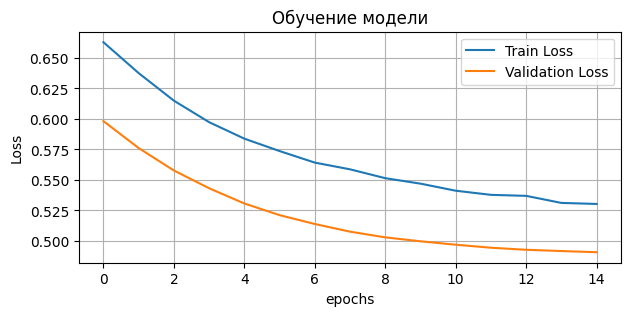

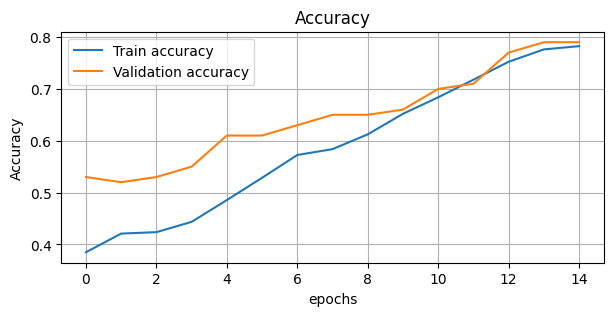

Accuracy на валидационных данных: 0.7900


In [100]:
model = MLPOne()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=1, type_data=2)
evaluate_model_binclf(model, test_loader)

В случае этого набора данных ситуация также улучшилась с добавлением скрытого слоя и функции активации в MLP. Accuracy выросло с 0.33 до 0.79. С ростом количества эпох лосс уменьшается, а accuracy растет.

Повторим эксперимент на третьем наборе данных

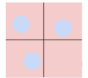

In [101]:
X, y = generate_third_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.9236, val loss 0.8944, train acc 0.0938, val acc 0.1319


  7%|▋         | 1/15 [00:03<00:49,  3.57s/it]

iteration 20, train loss 0.8562, val loss 0.8409, train acc 0.1250, val acc 0.1632
iteration 30, train loss 0.7802, val loss 0.7932, train acc 0.1562, val acc 0.1710


 13%|█▎        | 2/15 [00:06<00:43,  3.32s/it]

iteration 40, train loss 0.7778, val loss 0.7511, train acc 0.2031, val acc 0.1866


 20%|██        | 3/15 [00:09<00:39,  3.27s/it]

iteration 50, train loss 0.7098, val loss 0.7139, train acc 0.2812, val acc 0.2240
iteration 60, train loss 0.6934, val loss 0.6826, train acc 0.2969, val acc 0.2396


 27%|██▋       | 4/15 [00:15<00:44,  4.08s/it]

iteration 70, train loss 0.6858, val loss 0.6545, train acc 0.3438, val acc 0.2674


 33%|███▎      | 5/15 [00:18<00:37,  3.74s/it]

iteration 80, train loss 0.6482, val loss 0.6308, train acc 0.4250, val acc 0.2595
iteration 90, train loss 0.5852, val loss 0.6115, train acc 0.3281, val acc 0.3168


 40%|████      | 6/15 [00:21<00:32,  3.56s/it]

iteration 100, train loss 0.6178, val loss 0.5944, train acc 0.3594, val acc 0.3481
iteration 110, train loss 0.5496, val loss 0.5801, train acc 0.5156, val acc 0.3993


 47%|████▋     | 7/15 [00:25<00:28,  3.60s/it]

iteration 120, train loss 0.5849, val loss 0.5678, train acc 0.4688, val acc 0.4705


 53%|█████▎    | 8/15 [00:29<00:26,  3.72s/it]

iteration 130, train loss 0.5571, val loss 0.5570, train acc 0.5156, val acc 0.5000
iteration 140, train loss 0.4916, val loss 0.5477, train acc 0.5625, val acc 0.5451


 60%|██████    | 9/15 [00:32<00:21,  3.54s/it]

iteration 150, train loss 0.6021, val loss 0.5397, train acc 0.4531, val acc 0.5590


 67%|██████▋   | 10/15 [00:35<00:17,  3.42s/it]

iteration 160, train loss 0.5364, val loss 0.5326, train acc 0.7000, val acc 0.5668
iteration 170, train loss 0.4355, val loss 0.5262, train acc 0.6406, val acc 0.5668


 73%|███████▎  | 11/15 [00:39<00:14,  3.63s/it]

iteration 180, train loss 0.5644, val loss 0.5207, train acc 0.6250, val acc 0.5885
iteration 190, train loss 0.4921, val loss 0.5156, train acc 0.5938, val acc 0.5885


 80%|████████  | 12/15 [00:43<00:10,  3.64s/it]

iteration 200, train loss 0.4933, val loss 0.5108, train acc 0.6094, val acc 0.6259


 87%|████████▋ | 13/15 [00:46<00:06,  3.48s/it]

iteration 210, train loss 0.5437, val loss 0.5063, train acc 0.5781, val acc 0.6415
iteration 220, train loss 0.5168, val loss 0.5022, train acc 0.7031, val acc 0.6554


 93%|█████████▎| 14/15 [00:49<00:03,  3.44s/it]

iteration 230, train loss 0.5328, val loss 0.4982, train acc 0.5625, val acc 0.6632


100%|██████████| 15/15 [00:53<00:00,  3.58s/it]

iteration 240, train loss 0.4739, val loss 0.4946, train acc 0.6750, val acc 0.6632


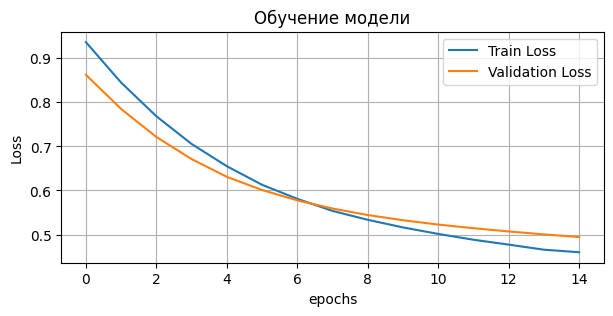

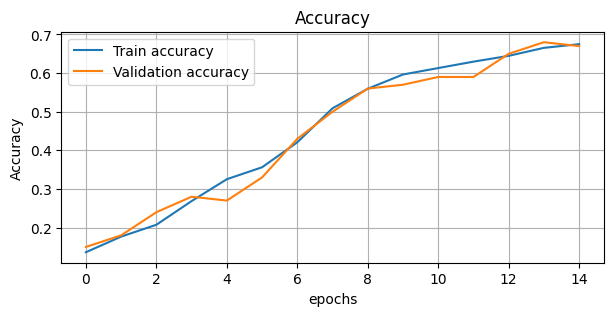

Accuracy на валидационных данных: 0.6700


In [102]:
model = MLPOne()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=1, type_data=3)
evaluate_model_binclf(model, test_loader)

В данном случае accuracy тоже увеличилось с 0.48 (случай MLP без скрытых слоев)до 0.67

Вывод: MLP c одним скрытым слоем и функцией активации ReLU показывает лучшие результаты, чем MLP без скрытых слоев.

Добавим второй скрытый слой

In [103]:
class MLPTwo(nn.Module):
  def __init__(self):
    super(MLPTwo, self).__init__()
    self.fc1 = nn.Linear(2, 8)
    self.ac1 = nn.ReLU()
    self.fc2 = nn.Linear(8, 16)
    self.ac2 = nn.ReLU()
    self.fc3 = nn.Linear(16, 1)
    #self.ac3 = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    x = self.ac2(x)
    x = self.fc3(x)
    #x = self.ac3(x)
    return x.squeeze(1)

Повторим эксперимент для первого набора данных

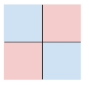

In [104]:
X, y = generate_first_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.6621, val loss 0.6788, train acc 0.5781, val acc 0.4618


  7%|▋         | 1/15 [00:04<00:56,  4.02s/it]

iteration 20, train loss 0.6532, val loss 0.6616, train acc 0.4844, val acc 0.4618
iteration 30, train loss 0.6447, val loss 0.6440, train acc 0.4688, val acc 0.4618


 13%|█▎        | 2/15 [00:07<00:47,  3.64s/it]

iteration 40, train loss 0.6030, val loss 0.6262, train acc 0.3906, val acc 0.4896


 20%|██        | 3/15 [00:12<00:52,  4.39s/it]

iteration 50, train loss 0.6044, val loss 0.6076, train acc 0.6250, val acc 0.5269
iteration 60, train loss 0.6001, val loss 0.5889, train acc 0.7031, val acc 0.5720


 27%|██▋       | 4/15 [00:16<00:45,  4.11s/it]

iteration 70, train loss 0.5471, val loss 0.5697, train acc 0.6562, val acc 0.6606


 33%|███▎      | 5/15 [00:19<00:37,  3.80s/it]

iteration 80, train loss 0.5521, val loss 0.5497, train acc 0.6500, val acc 0.6901
iteration 90, train loss 0.5393, val loss 0.5293, train acc 0.7656, val acc 0.7179


 40%|████      | 6/15 [00:23<00:33,  3.74s/it]

iteration 100, train loss 0.4733, val loss 0.5085, train acc 0.8594, val acc 0.7691
iteration 110, train loss 0.4717, val loss 0.4881, train acc 0.9219, val acc 0.7908


 47%|████▋     | 7/15 [00:27<00:30,  3.87s/it]

iteration 120, train loss 0.4491, val loss 0.4680, train acc 0.8750, val acc 0.8203


 53%|█████▎    | 8/15 [00:30<00:25,  3.64s/it]

iteration 130, train loss 0.4106, val loss 0.4475, train acc 0.8594, val acc 0.8203
iteration 140, train loss 0.4129, val loss 0.4271, train acc 0.8594, val acc 0.8203


 60%|██████    | 9/15 [00:33<00:20,  3.50s/it]

iteration 150, train loss 0.3391, val loss 0.4065, train acc 0.8906, val acc 0.8637
iteration 160, train loss 0.3660, val loss 0.3860, train acc 0.9250, val acc 0.8637


 67%|██████▋   | 10/15 [00:38<00:19,  3.81s/it]

iteration 170, train loss 0.3078, val loss 0.3664, train acc 0.9375, val acc 0.8637


 73%|███████▎  | 11/15 [00:41<00:15,  3.75s/it]

iteration 180, train loss 0.3446, val loss 0.3475, train acc 0.9219, val acc 0.8776
iteration 190, train loss 0.2947, val loss 0.3294, train acc 0.8906, val acc 0.8915


 80%|████████  | 12/15 [00:45<00:10,  3.62s/it]

iteration 200, train loss 0.3098, val loss 0.3124, train acc 0.9531, val acc 0.9271


 87%|████████▋ | 13/15 [00:48<00:07,  3.52s/it]

iteration 210, train loss 0.2750, val loss 0.2964, train acc 0.9375, val acc 0.9271
iteration 220, train loss 0.2592, val loss 0.2818, train acc 0.9219, val acc 0.9271


 93%|█████████▎| 14/15 [00:53<00:03,  3.84s/it]

iteration 230, train loss 0.2515, val loss 0.2681, train acc 0.8906, val acc 0.9271


100%|██████████| 15/15 [00:56<00:00,  3.75s/it]

iteration 240, train loss 0.2103, val loss 0.2557, train acc 1.0000, val acc 0.9349


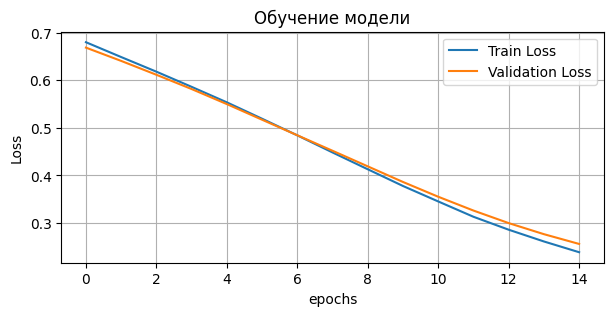

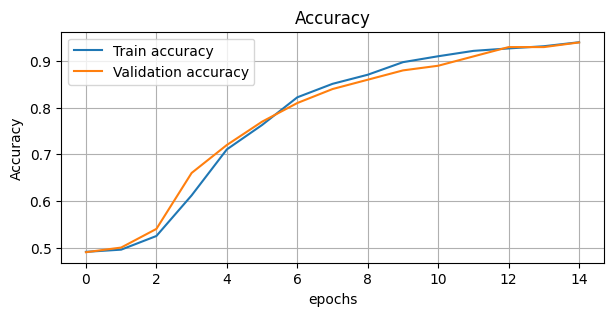

Accuracy на валидационных данных: 0.9400


In [106]:
model = MLPTwo()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=2, type_data=1)
evaluate_model_binclf(model, test_loader)

Как видно по графику, с двумя скрытыми слоями модель работает уже гораздо лучше чем в 1 и во 2 случаях. Accuracy выросла до 0.94 (за 15 эпох).

Повторим эксперимент на втором наборе данных

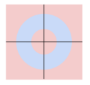

In [111]:
X, y = generate_second_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.6935, val loss 0.6763, train acc 0.1719, val acc 0.2960


  7%|▋         | 1/15 [00:03<00:53,  3.85s/it]

iteration 20, train loss 0.6876, val loss 0.6507, train acc 0.2969, val acc 0.3568
iteration 30, train loss 0.6208, val loss 0.6298, train acc 0.4062, val acc 0.4158


 13%|█▎        | 2/15 [00:07<00:45,  3.53s/it]

iteration 40, train loss 0.6295, val loss 0.6122, train acc 0.3750, val acc 0.4826


 20%|██        | 3/15 [00:10<00:40,  3.35s/it]

iteration 50, train loss 0.6664, val loss 0.5969, train acc 0.3750, val acc 0.4748
iteration 60, train loss 0.5277, val loss 0.5847, train acc 0.5312, val acc 0.4826


 27%|██▋       | 4/15 [00:14<00:41,  3.82s/it]

iteration 70, train loss 0.6585, val loss 0.5750, train acc 0.4375, val acc 0.4905
iteration 80, train loss 0.5260, val loss 0.5669, train acc 0.5250, val acc 0.5139


 33%|███▎      | 5/15 [00:18<00:38,  3.85s/it]

iteration 90, train loss 0.6316, val loss 0.5604, train acc 0.4531, val acc 0.6536


 40%|████      | 6/15 [00:21<00:32,  3.62s/it]

iteration 100, train loss 0.4806, val loss 0.5548, train acc 0.6562, val acc 0.6571
iteration 110, train loss 0.5554, val loss 0.5504, train acc 0.7500, val acc 0.6649


 47%|████▋     | 7/15 [00:25<00:28,  3.60s/it]

iteration 120, train loss 0.4769, val loss 0.5471, train acc 0.8125, val acc 0.6962


 53%|█████▎    | 8/15 [00:29<00:25,  3.69s/it]

iteration 130, train loss 0.5070, val loss 0.5444, train acc 0.7969, val acc 0.7396
iteration 140, train loss 0.5602, val loss 0.5429, train acc 0.7500, val acc 0.7630


 60%|██████    | 9/15 [00:32<00:21,  3.58s/it]

iteration 150, train loss 0.4850, val loss 0.5422, train acc 0.8125, val acc 0.7630
iteration 160, train loss 0.4667, val loss 0.5423, train acc 0.8000, val acc 0.7630


 67%|██████▋   | 10/15 [00:35<00:17,  3.43s/it]

iteration 170, train loss 0.4734, val loss 0.5428, train acc 0.8281, val acc 0.7630


 73%|███████▎  | 11/15 [00:39<00:14,  3.51s/it]

iteration 180, train loss 0.4752, val loss 0.5438, train acc 0.8281, val acc 0.7630
iteration 190, train loss 0.4876, val loss 0.5445, train acc 0.7969, val acc 0.7630


 80%|████████  | 12/15 [00:43<00:10,  3.66s/it]

iteration 200, train loss 0.5464, val loss 0.5454, train acc 0.7656, val acc 0.7630


 87%|████████▋ | 13/15 [00:46<00:06,  3.49s/it]

iteration 210, train loss 0.5083, val loss 0.5459, train acc 0.7812, val acc 0.7630
iteration 220, train loss 0.4442, val loss 0.5459, train acc 0.8438, val acc 0.7630


 93%|█████████▎| 14/15 [00:49<00:03,  3.40s/it]

iteration 230, train loss 0.4542, val loss 0.5460, train acc 0.8281, val acc 0.7630
iteration 240, train loss 0.4638, val loss 0.5462, train acc 0.8250, val acc 0.7630


100%|██████████| 15/15 [00:53<00:00,  3.54s/it]


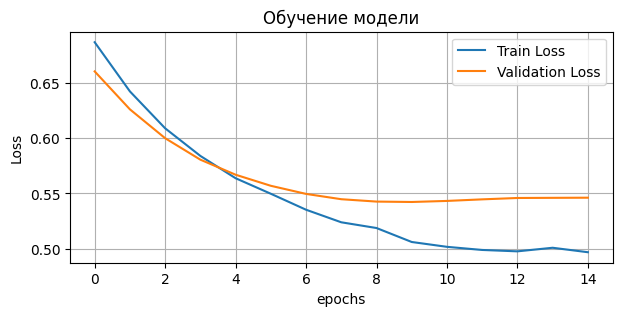

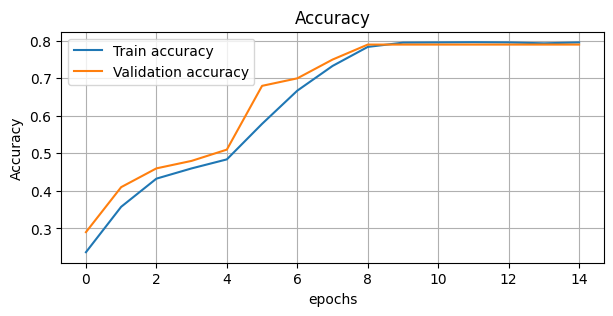

Accuracy на валидационных данных: 0.7900


In [112]:
model = MLPTwo()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=2, type_data=2)
evaluate_model_binclf(model, test_loader)

На этом наборе данных accuracy также стала больше с добавлением второго скрытого слоя. Правда, на последних 5 эпохах accuracy на валидационных данных не менялась.

Повторим эксперимент на третьем наборе данных

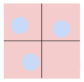

In [115]:
X, y = generate_third_data(1100, 2)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=100, stratify=y)

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/15 [00:00<?, ?it/s]

iteration 10, train loss 0.7191, val loss 0.7036, train acc 0.1719, val acc 0.1181


  7%|▋         | 1/15 [00:03<00:52,  3.74s/it]

iteration 20, train loss 0.6810, val loss 0.6670, train acc 0.1719, val acc 0.1181
iteration 30, train loss 0.6435, val loss 0.6315, train acc 0.1406, val acc 0.1693


 13%|█▎        | 2/15 [00:06<00:44,  3.41s/it]

iteration 40, train loss 0.6104, val loss 0.5975, train acc 0.2031, val acc 0.3030


 20%|██        | 3/15 [00:11<00:45,  3.78s/it]

iteration 50, train loss 0.5412, val loss 0.5630, train acc 0.4219, val acc 0.3385
iteration 60, train loss 0.5353, val loss 0.5291, train acc 0.3750, val acc 0.4253


 27%|██▋       | 4/15 [00:14<00:40,  3.66s/it]

iteration 70, train loss 0.5055, val loss 0.4962, train acc 0.4062, val acc 0.4983


 33%|███▎      | 5/15 [00:17<00:34,  3.50s/it]

iteration 80, train loss 0.4460, val loss 0.4654, train acc 0.8500, val acc 0.8012
iteration 90, train loss 0.4436, val loss 0.4364, train acc 0.8438, val acc 0.8524


 40%|████      | 6/15 [00:21<00:32,  3.57s/it]

iteration 100, train loss 0.4784, val loss 0.4119, train acc 0.7812, val acc 0.8819
iteration 110, train loss 0.3434, val loss 0.3937, train acc 0.9219, val acc 0.8819


 47%|████▋     | 7/15 [00:25<00:29,  3.72s/it]

iteration 120, train loss 0.4565, val loss 0.3797, train acc 0.8125, val acc 0.8819


 53%|█████▎    | 8/15 [00:28<00:24,  3.53s/it]

iteration 130, train loss 0.3575, val loss 0.3718, train acc 0.8906, val acc 0.8819
iteration 140, train loss 0.3272, val loss 0.3673, train acc 0.8906, val acc 0.8819


 60%|██████    | 9/15 [00:31<00:20,  3.40s/it]

iteration 150, train loss 0.2654, val loss 0.3647, train acc 0.9219, val acc 0.8819
iteration 160, train loss 0.4219, val loss 0.3635, train acc 0.8250, val acc 0.8819


 67%|██████▋   | 10/15 [00:35<00:18,  3.62s/it]

iteration 170, train loss 0.3110, val loss 0.3630, train acc 0.9062, val acc 0.8819


 73%|███████▎  | 11/15 [00:39<00:14,  3.67s/it]

iteration 180, train loss 0.5439, val loss 0.3621, train acc 0.7812, val acc 0.8819
iteration 190, train loss 0.3254, val loss 0.3613, train acc 0.8750, val acc 0.8819


 80%|████████  | 12/15 [00:42<00:10,  3.53s/it]

iteration 200, train loss 0.4245, val loss 0.3609, train acc 0.8281, val acc 0.8819


 87%|████████▋ | 13/15 [00:46<00:07,  3.54s/it]

iteration 210, train loss 0.3765, val loss 0.3604, train acc 0.8438, val acc 0.8819
iteration 220, train loss 0.3166, val loss 0.3604, train acc 0.8906, val acc 0.8819


 93%|█████████▎| 14/15 [00:50<00:03,  3.62s/it]

iteration 230, train loss 0.2110, val loss 0.3595, train acc 0.9531, val acc 0.8819


100%|██████████| 15/15 [00:53<00:00,  3.57s/it]

iteration 240, train loss 0.3164, val loss 0.3589, train acc 0.9000, val acc 0.8819


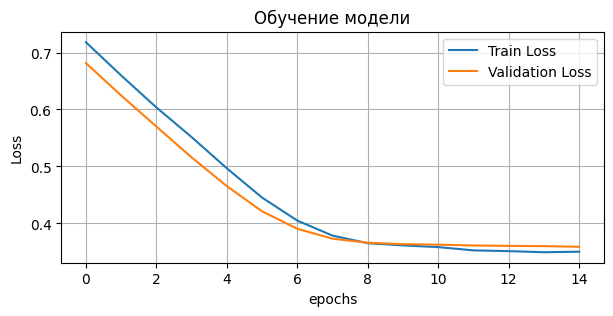

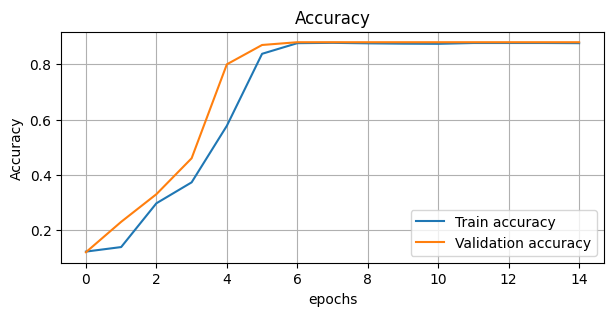

Accuracy на валидационных данных: 0.8800


In [116]:
model = MLPTwo()
train_model_binclf(model, train_loader, test_loader, 15, hidden_layers=2, type_data=3)
evaluate_model_binclf(model, test_loader)

В данном случае accuracy тоже выросла по сравнению со случаем MLP с одним скрытым слоем.

Вывод: Модель с 2 скрытыми слоями и функцией активации ReLU предсказывает классы точек лучше, чем модели в остальных случаях, так как улавливает больше закономерностей в данных.

Часть 2 (2 балла)
2.1  Скачайте и подготовьте данные Wine Quality: объедините данные для двух типов вина, разделите данные на обучающие и валидационные, выполните нормализацию данных.

2.2  На этих данных решите задачу классификации (целевая переменная target целочисленная, но работать с ней нужно как с категориальной). Обучите MLP для решения данной задачи.  Варьируйте значения гиперпараметров (размер и число скрытых слоев, функции активации, learning rate и batch_size, оптимайзер и его параметры), оценивая значение лосса в процессе обучения и результаты на валидационной выборке. Постарайтесь получить как можно лучшее качество модели.

2.3  Качественно оцените результаты лучшей модели. Какие классы модель путает чаще всего, какие классы определяются наиболее хорошо и плохо.


In [119]:
!pip install ucimlrepo

In [120]:
from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)

X = wine_quality.data.features
y = wine_quality.data.targets

In [121]:
X.shape

(6497, 11)

In [122]:
X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [208]:
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [124]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)

In [125]:
X_train.shape

(5197, 11)

1) Попробуем использовать модель с несколькими линейными слоями и функциями активации ReLU

In [126]:
class MLP(nn.Module):
    def __init__(self, in_features=11, num_classes=7):
        super(MLP, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True)
        )

        self.net2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.net1(x)
        x = self.net2(x)

        return x


In [146]:
def train_model_wine(model, train_loader, test_loader, epochs, criterion=None, optimizer=None):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            target = target.long()

            if target.dim() > 1:
                target = target.squeeze()

            target = target-3

            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        #scheduler.step()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in test_loader:
                target = target.long()

                if target.dim() > 1:
                    target = target.squeeze()

                target = target-3

                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()

                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_loss /= len(test_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
                  f"Train Acc: {epoch_accuracy:.2f} | Val Acc: {val_accuracy:.2f} | ")
                  #f"LR: {scheduler.get_last_lr()[0]:.6f}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss during Training')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy during Training')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #return train_losses, val_losses, train_accuracies, val_accuracies

In [162]:
def evaluate_model_wine(model, test_loader):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, target in test_loader:
            target = target.long()

            if target.dim() > 1:
                target = target.squeeze()

            target = target-3

            output = model(data)
            _, predicted = torch.max(output.data, 1)

            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    val_accuracy = correct_val / total_val
    return f"Accuracy на валидационных данных: {val_accuracy:.2f}"

In [128]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train.values).int()
x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test.values).int()

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(x_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipython-input-3001555032.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float32)
/tmp/ipython-input-3001555032.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)


 33%|███▎      | 10/30 [00:03<00:07,  2.81it/s]

Epoch 10/30 | Train Loss: 1.6167 | Val Loss: 1.6316 | Train Acc: 0.55 | Val Acc: 0.53 | 


 67%|██████▋   | 20/30 [00:06<00:02,  3.62it/s]

Epoch 20/30 | Train Loss: 1.6053 | Val Loss: 1.6214 | Train Acc: 0.56 | Val Acc: 0.54 | 


100%|██████████| 30/30 [00:08<00:00,  3.41it/s]

Epoch 30/30 | Train Loss: 1.5979 | Val Loss: 1.6165 | Train Acc: 0.57 | Val Acc: 0.55 | 


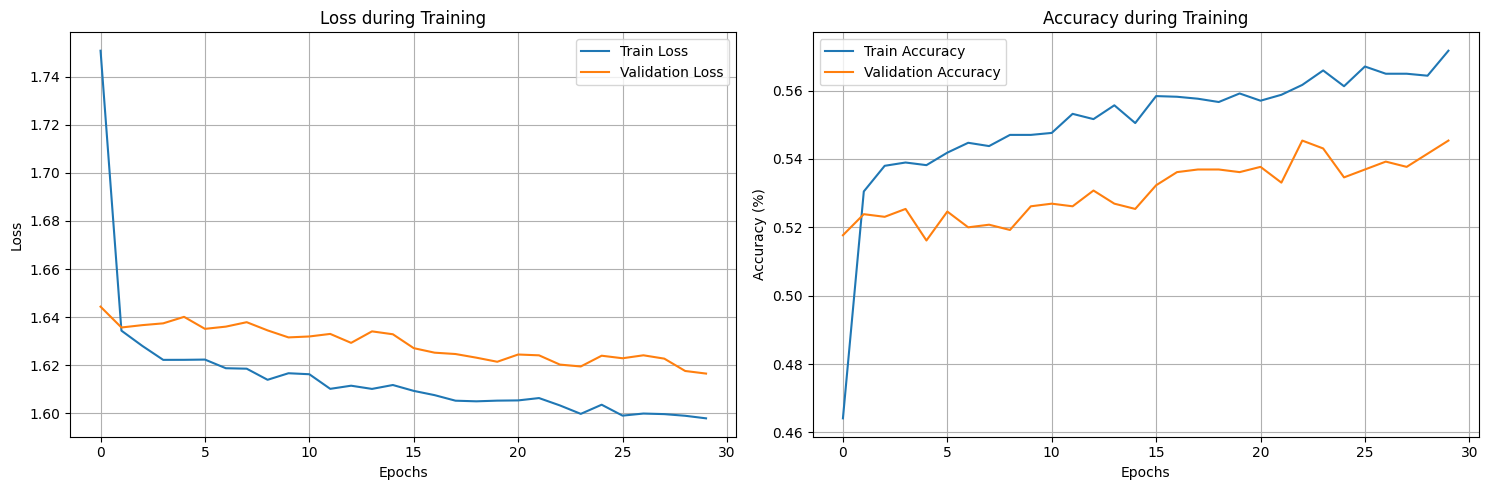

In [164]:
model = MLP()
train_model_wine(model, train_loader, test_loader, 30)

In [165]:
evaluate_model_wine(model, test_loader)

'Accuracy на валидационных данных: 0.55'

Итак, accuracy получилась 0.55 при CrossEntropyLoss, learning_rate = 0.001, optimizer = AdamW

Попробуем увеличить количество эпох с 30 до 50

 20%|██        | 10/50 [00:03<00:10,  3.82it/s]

Epoch 10/50 | Train Loss: 1.6025 | Val Loss: 1.6160 | Train Acc: 0.56 | Val Acc: 0.54 | 


 40%|████      | 20/50 [00:05<00:07,  3.95it/s]

Epoch 20/50 | Train Loss: 1.5907 | Val Loss: 1.6142 | Train Acc: 0.57 | Val Acc: 0.54 | 


 60%|██████    | 30/50 [00:08<00:05,  3.92it/s]

Epoch 30/50 | Train Loss: 1.5818 | Val Loss: 1.6086 | Train Acc: 0.58 | Val Acc: 0.55 | 


 80%|████████  | 40/50 [00:10<00:02,  3.86it/s]

Epoch 40/50 | Train Loss: 1.5693 | Val Loss: 1.6024 | Train Acc: 0.60 | Val Acc: 0.56 | 


100%|██████████| 50/50 [00:14<00:00,  3.54it/s]

Epoch 50/50 | Train Loss: 1.5648 | Val Loss: 1.5982 | Train Acc: 0.60 | Val Acc: 0.56 | 


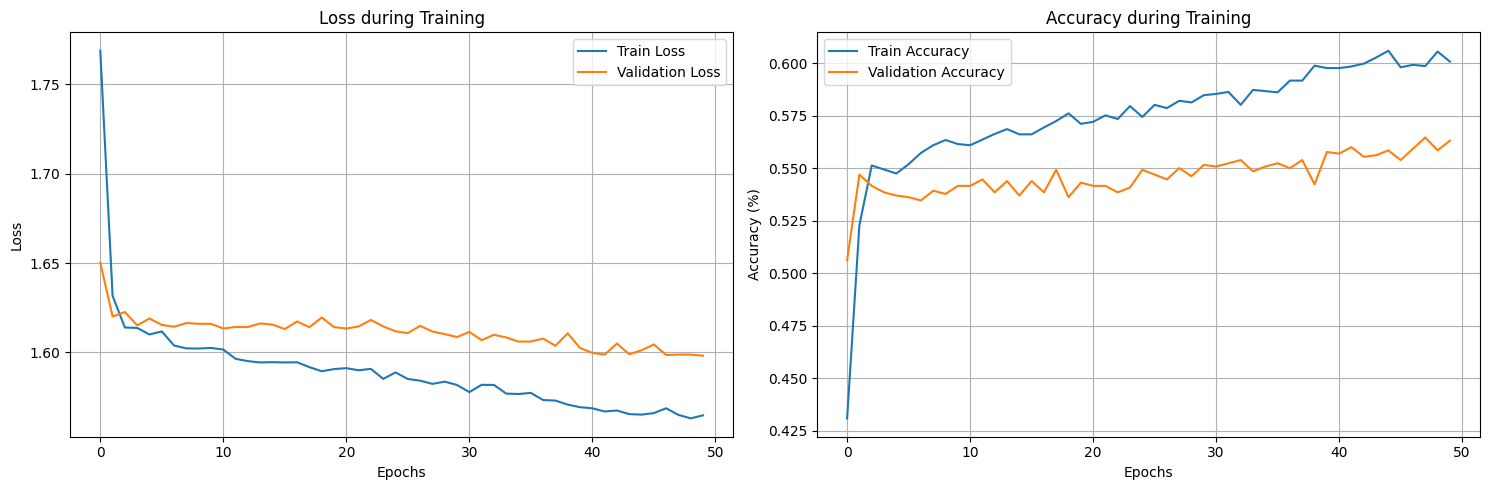

'Accuracy на валидационных данных: 0.56'

In [166]:
model = MLP()
train_model_wine(model, train_loader, test_loader, 50)
evaluate_model_wine(model, test_loader)

Произошло небольшое улучшение, на 0.01, теперь accuracy 0.56

Попробуем другую функцию активации (вместо ReLU возьмем Tanh после первых двух слоев)

In [167]:
class MLP(nn.Module):
    def __init__(self, in_features=11, num_classes=7):
        super(MLP, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh()
        )

        self.net2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.net1(x)
        x = self.net2(x)

        return x

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 10/50 [00:06<00:21,  1.90it/s]

Epoch 10/50 | Train Loss: 1.6188 | Val Loss: 1.6354 | Train Acc: 0.55 | Val Acc: 0.53 | 


 40%|████      | 20/50 [00:10<00:10,  2.96it/s]

Epoch 20/50 | Train Loss: 1.6050 | Val Loss: 1.6274 | Train Acc: 0.56 | Val Acc: 0.53 | 


 60%|██████    | 30/50 [00:13<00:05,  3.83it/s]

Epoch 30/50 | Train Loss: 1.5990 | Val Loss: 1.6220 | Train Acc: 0.57 | Val Acc: 0.54 | 


 80%|████████  | 40/50 [00:16<00:03,  3.06it/s]

Epoch 40/50 | Train Loss: 1.5947 | Val Loss: 1.6178 | Train Acc: 0.57 | Val Acc: 0.54 | 


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]

Epoch 50/50 | Train Loss: 1.5906 | Val Loss: 1.6162 | Train Acc: 0.57 | Val Acc: 0.54 | 


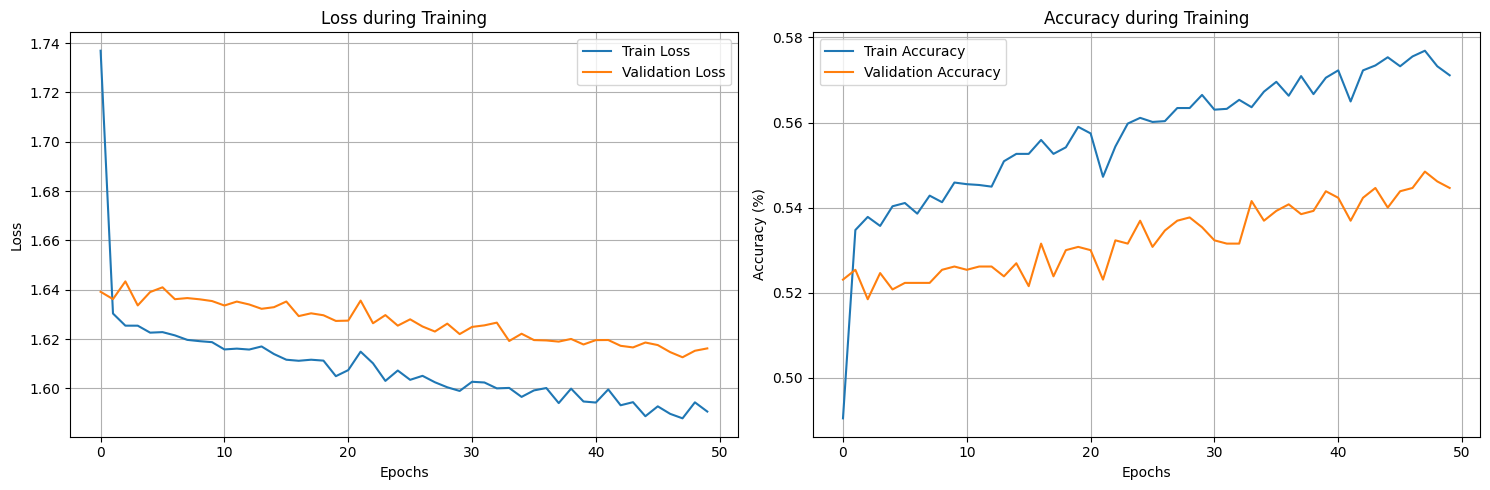

'Accuracy на валидационных данных: 0.54'

In [168]:
model = MLP()
train_model_wine(model, train_loader, test_loader, 50)
evaluate_model_wine(model, test_loader)

Accuracy стала чуть хуже

Возьмем другой learning_rate и функции активации ReLU

In [169]:
class MLP(nn.Module):
    def __init__(self, in_features=11, num_classes=7):
        super(MLP, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True)
        )

        self.net2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.net1(x)
        x = self.net2(x)

        return x

Попробуем различные значения learning_rate для оптимизатора

Learning rate 0.0001


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 10/50 [00:04<00:12,  3.26it/s]

Epoch 10/50 | Train Loss: 1.6484 | Val Loss: 1.6419 | Train Acc: 0.52 | Val Acc: 0.53 | 


 40%|████      | 20/50 [00:06<00:07,  3.86it/s]

Epoch 20/50 | Train Loss: 1.6265 | Val Loss: 1.6282 | Train Acc: 0.54 | Val Acc: 0.53 | 


 60%|██████    | 30/50 [00:09<00:05,  3.98it/s]

Epoch 30/50 | Train Loss: 1.6186 | Val Loss: 1.6257 | Train Acc: 0.55 | Val Acc: 0.53 | 


 80%|████████  | 40/50 [00:11<00:02,  3.99it/s]

Epoch 40/50 | Train Loss: 1.6111 | Val Loss: 1.6248 | Train Acc: 0.56 | Val Acc: 0.53 | 


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]

Epoch 50/50 | Train Loss: 1.6090 | Val Loss: 1.6226 | Train Acc: 0.56 | Val Acc: 0.54 | 


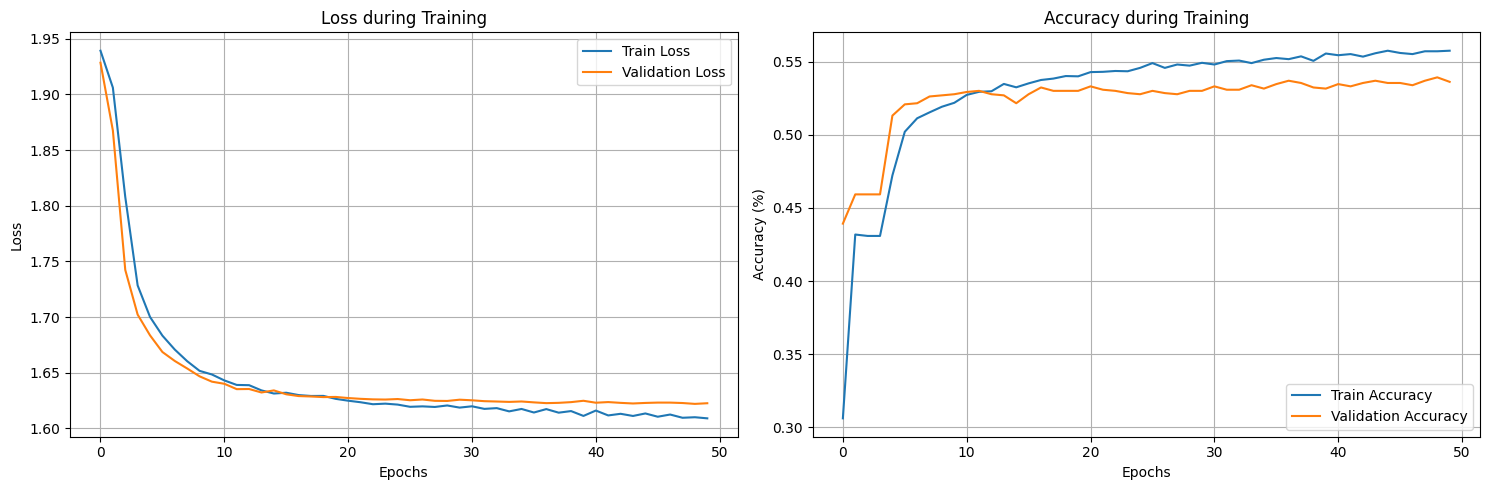

Learning rate 0.0005


 20%|██        | 10/50 [00:02<00:09,  4.01it/s]

Epoch 10/50 | Train Loss: 1.6087 | Val Loss: 1.6205 | Train Acc: 0.55 | Val Acc: 0.54 | 


 40%|████      | 20/50 [00:05<00:07,  4.12it/s]

Epoch 20/50 | Train Loss: 1.5979 | Val Loss: 1.6189 | Train Acc: 0.57 | Val Acc: 0.54 | 


 60%|██████    | 30/50 [00:08<00:06,  3.12it/s]

Epoch 30/50 | Train Loss: 1.5902 | Val Loss: 1.6182 | Train Acc: 0.58 | Val Acc: 0.54 | 


 80%|████████  | 40/50 [00:11<00:03,  3.10it/s]

Epoch 40/50 | Train Loss: 1.5819 | Val Loss: 1.6153 | Train Acc: 0.58 | Val Acc: 0.55 | 


100%|██████████| 50/50 [00:14<00:00,  3.54it/s]

Epoch 50/50 | Train Loss: 1.5829 | Val Loss: 1.6089 | Train Acc: 0.59 | Val Acc: 0.55 | 


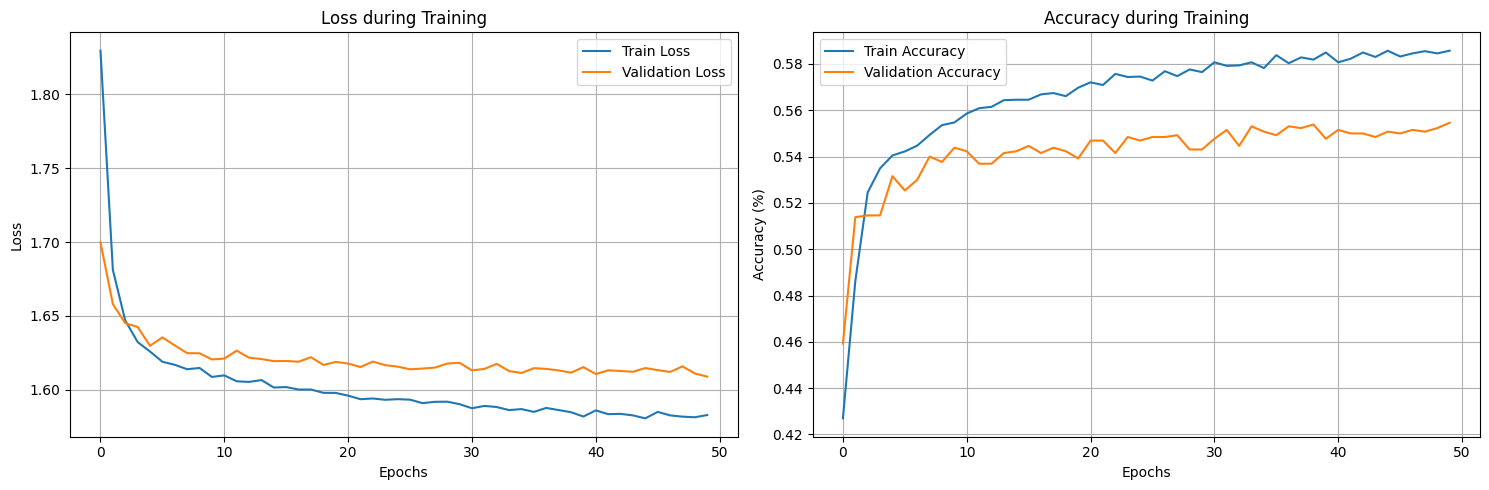

Learning rate 0.001


 20%|██        | 10/50 [00:02<00:10,  3.71it/s]

Epoch 10/50 | Train Loss: 1.6044 | Val Loss: 1.6245 | Train Acc: 0.56 | Val Acc: 0.54 | 


 40%|████      | 20/50 [00:05<00:08,  3.68it/s]

Epoch 20/50 | Train Loss: 1.5903 | Val Loss: 1.6154 | Train Acc: 0.58 | Val Acc: 0.55 | 


 60%|██████    | 30/50 [00:07<00:05,  3.98it/s]

Epoch 30/50 | Train Loss: 1.5818 | Val Loss: 1.6119 | Train Acc: 0.59 | Val Acc: 0.55 | 


 80%|████████  | 40/50 [00:11<00:03,  2.99it/s]

Epoch 40/50 | Train Loss: 1.5704 | Val Loss: 1.6103 | Train Acc: 0.60 | Val Acc: 0.55 | 


100%|██████████| 50/50 [00:13<00:00,  3.57it/s]

Epoch 50/50 | Train Loss: 1.5656 | Val Loss: 1.6084 | Train Acc: 0.60 | Val Acc: 0.55 | 


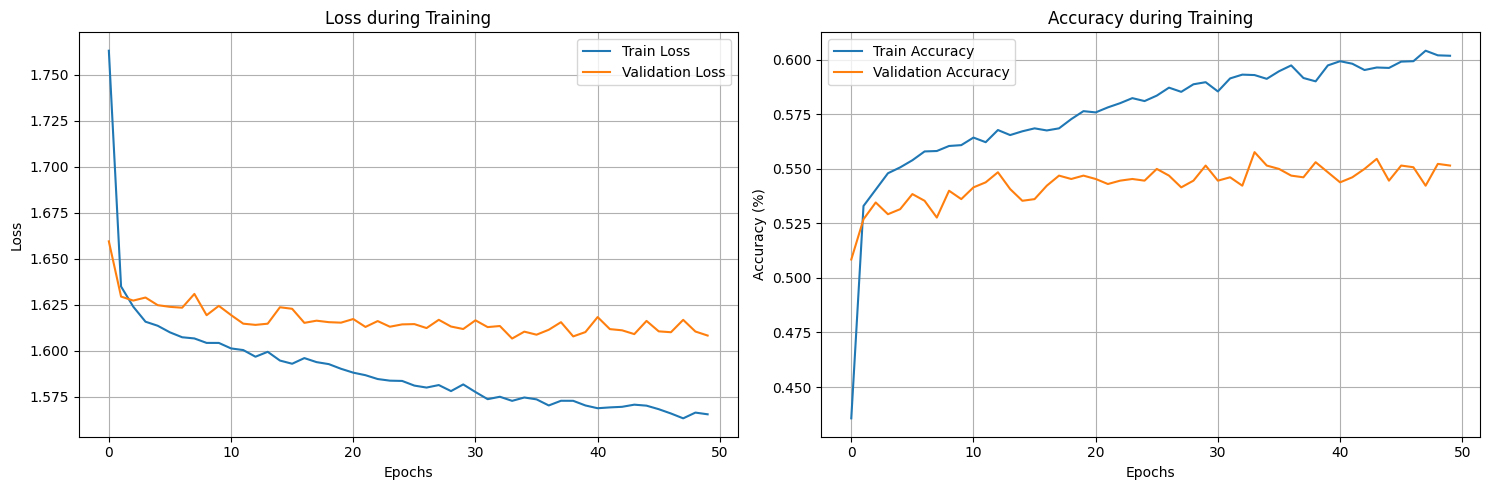

Learning rate 0.005


 20%|██        | 10/50 [00:02<00:10,  3.80it/s]

Epoch 10/50 | Train Loss: 1.6125 | Val Loss: 1.6349 | Train Acc: 0.55 | Val Acc: 0.53 | 


 40%|████      | 20/50 [00:05<00:08,  3.42it/s]

Epoch 20/50 | Train Loss: 1.5920 | Val Loss: 1.6269 | Train Acc: 0.57 | Val Acc: 0.54 | 


 60%|██████    | 30/50 [00:08<00:07,  2.69it/s]

Epoch 30/50 | Train Loss: 1.5972 | Val Loss: 1.6237 | Train Acc: 0.57 | Val Acc: 0.54 | 


 80%|████████  | 40/50 [00:12<00:03,  3.33it/s]

Epoch 40/50 | Train Loss: 1.6035 | Val Loss: 1.6334 | Train Acc: 0.56 | Val Acc: 0.53 | 


100%|██████████| 50/50 [00:14<00:00,  3.35it/s]

Epoch 50/50 | Train Loss: 1.5883 | Val Loss: 1.6255 | Train Acc: 0.58 | Val Acc: 0.54 | 


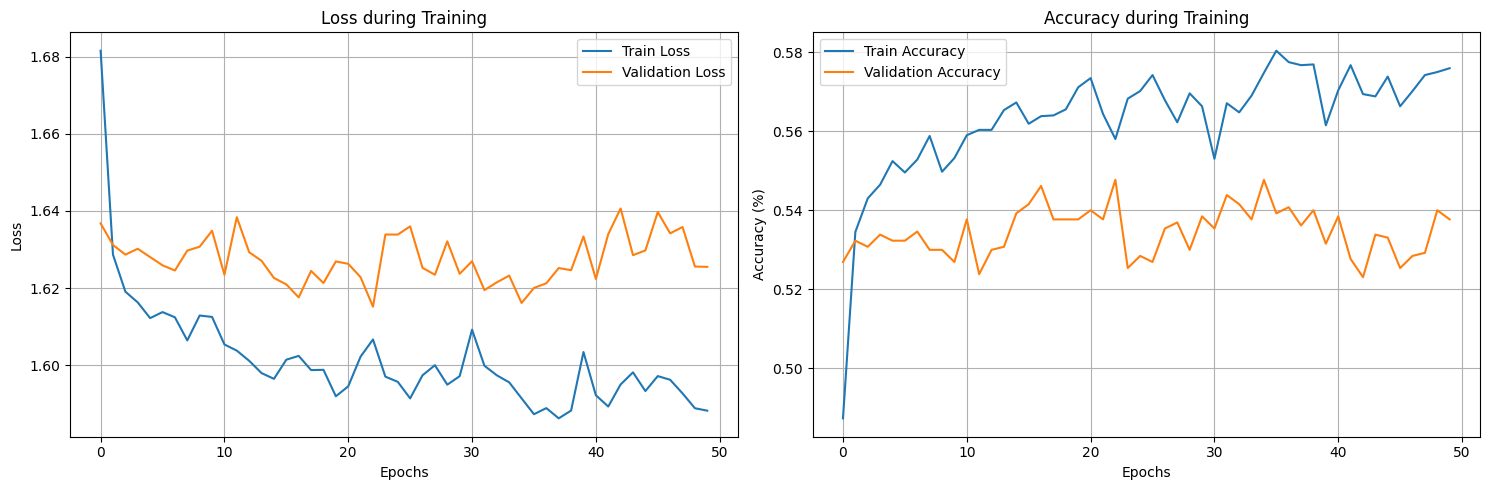

In [171]:
learning_rates = [0.0001, 0.0005, 0.001, 0.005]
for lr in learning_rates:
  model = MLP()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  print(f"Learning rate {lr}")
  train_model_wine(model, train_loader, test_loader, 50, optimizer=optimizer)
  evaluate_model_wine(model, test_loader)

При learning_rate = 0.005 модель ведет себя нестабильно. При других значениях параметра accuracy не лучше, чем было получено с lr = 0.001 и функцией активации ReLU.

Попробуем изменить количество нейронов в скрытых слоях, количество слоев и применить dropout

In [173]:
class MLP(nn.Module):
    def __init__(self, in_features=11, num_classes=7):
        super(MLP, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU()
        )

        self.net2 = nn.Sequential(
            nn.Linear(128, num_classes),
            nn.Dropout(),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.net1(x)
        x = self.net2(x)

        return x

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 10/50 [00:06<00:31,  1.29it/s]

Epoch 10/50 | Train Loss: 1.7274 | Val Loss: 1.6268 | Train Acc: 0.39 | Val Acc: 0.54 | 


 40%|████      | 20/50 [00:10<00:08,  3.62it/s]

Epoch 20/50 | Train Loss: 1.7260 | Val Loss: 1.6310 | Train Acc: 0.39 | Val Acc: 0.52 | 


 60%|██████    | 30/50 [00:12<00:04,  4.43it/s]

Epoch 30/50 | Train Loss: 1.7312 | Val Loss: 1.6167 | Train Acc: 0.38 | Val Acc: 0.55 | 


 80%|████████  | 40/50 [00:15<00:02,  4.45it/s]

Epoch 40/50 | Train Loss: 1.7232 | Val Loss: 1.6187 | Train Acc: 0.39 | Val Acc: 0.54 | 


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

Epoch 50/50 | Train Loss: 1.7210 | Val Loss: 1.6229 | Train Acc: 0.39 | Val Acc: 0.54 | 


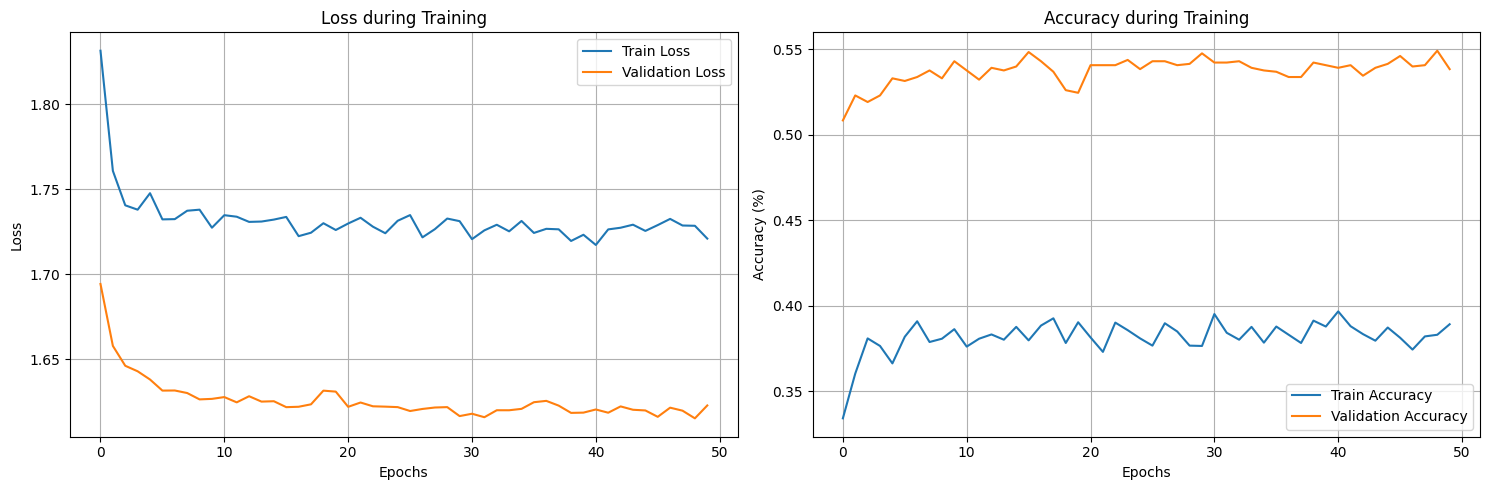

'Accuracy на валидационных данных: 0.54'

In [175]:
model = MLP()
train_model_wine(model, train_loader, test_loader, 50)
evaluate_model_wine(model, test_loader)

Лучше не стало

Изменим оптимайзер, попробуем  стохастический градиентный спуск.


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 10/50 [00:06<00:25,  1.59it/s]

Epoch 10/50 | Train Loss: 1.8203 | Val Loss: 1.8011 | Train Acc: 0.32 | Val Acc: 0.46 | 


 40%|████      | 20/50 [00:09<00:08,  3.34it/s]

Epoch 20/50 | Train Loss: 1.7900 | Val Loss: 1.7467 | Train Acc: 0.33 | Val Acc: 0.49 | 


 62%|██████▏   | 31/50 [00:12<00:03,  5.21it/s]

Epoch 30/50 | Train Loss: 1.7887 | Val Loss: 1.7243 | Train Acc: 0.33 | Val Acc: 0.49 | 


 82%|████████▏ | 41/50 [00:13<00:01,  5.37it/s]

Epoch 40/50 | Train Loss: 1.7905 | Val Loss: 1.7094 | Train Acc: 0.33 | Val Acc: 0.50 | 


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 50/50 | Train Loss: 1.7768 | Val Loss: 1.6966 | Train Acc: 0.35 | Val Acc: 0.49 | 


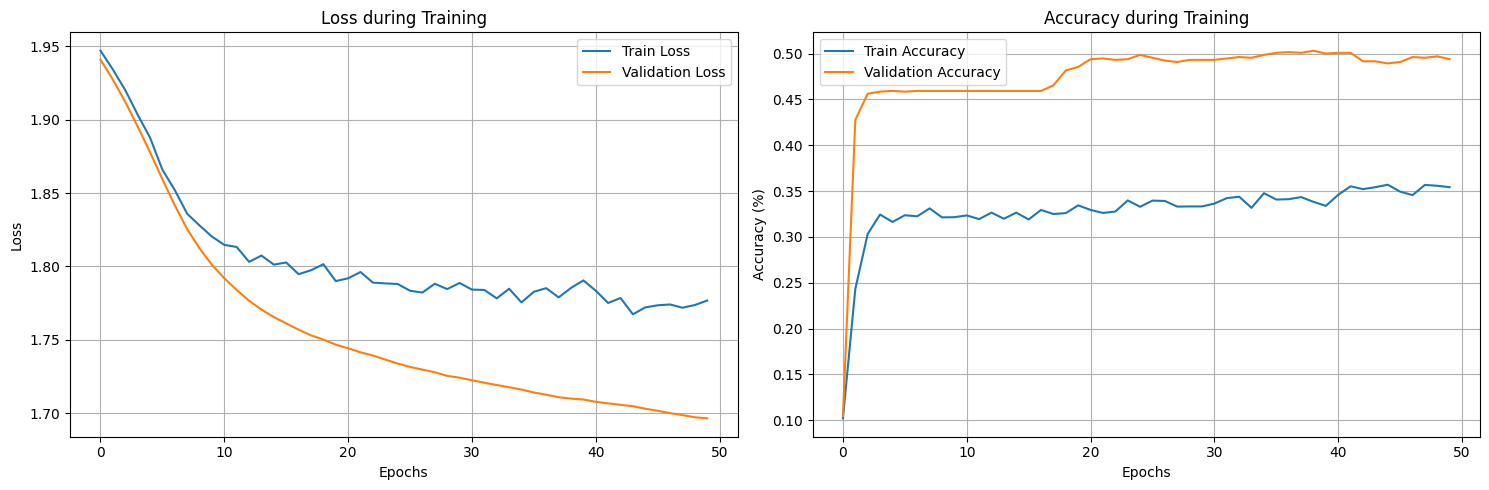

'Accuracy на валидационных данных: 0.49'

In [177]:
model = MLP()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_model_wine(model, train_loader, test_loader, 50, optimizer=optimizer)
evaluate_model_wine(model, test_loader)

Accuracy стала сильно меньше

Попробуем Adagrad в качестве оптимайзера.

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 10/50 [00:05<00:21,  1.88it/s]

Epoch 10/50 | Train Loss: 1.7846 | Val Loss: 1.7303 | Train Acc: 0.35 | Val Acc: 0.50 | 


 40%|████      | 20/50 [00:09<00:11,  2.56it/s]

Epoch 20/50 | Train Loss: 1.7640 | Val Loss: 1.6957 | Train Acc: 0.37 | Val Acc: 0.52 | 


 60%|██████    | 30/50 [00:11<00:04,  4.62it/s]

Epoch 30/50 | Train Loss: 1.7592 | Val Loss: 1.6800 | Train Acc: 0.37 | Val Acc: 0.53 | 


 80%|████████  | 40/50 [00:13<00:02,  4.86it/s]

Epoch 40/50 | Train Loss: 1.7580 | Val Loss: 1.6711 | Train Acc: 0.37 | Val Acc: 0.52 | 


100%|██████████| 50/50 [00:16<00:00,  3.03it/s]

Epoch 50/50 | Train Loss: 1.7483 | Val Loss: 1.6644 | Train Acc: 0.38 | Val Acc: 0.52 | 


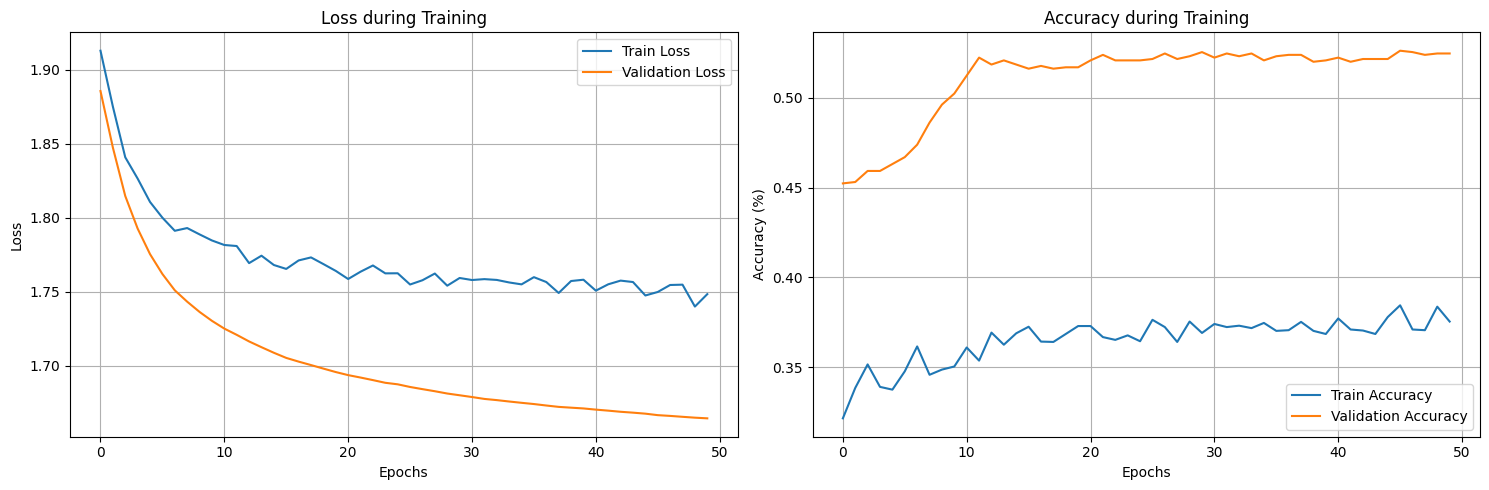

'Accuracy на валидационных данных: 0.52'

In [179]:
model = MLP()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
train_model_wine(model, train_loader, test_loader, 50, optimizer=optimizer)
evaluate_model_wine(model, test_loader)

С этим оптимайзером модель также не стала работать лучше.

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 10/50 [00:05<00:23,  1.69it/s]

Epoch 10/50 | Train Loss: 1.9359 | Val Loss: 1.9352 | Train Acc: 0.25 | Val Acc: 0.29 | 


 40%|████      | 20/50 [00:10<00:15,  1.93it/s]

Epoch 20/50 | Train Loss: 1.9204 | Val Loss: 1.9203 | Train Acc: 0.32 | Val Acc: 0.39 | 


 60%|██████    | 30/50 [00:14<00:05,  3.69it/s]

Epoch 30/50 | Train Loss: 1.9025 | Val Loss: 1.9030 | Train Acc: 0.34 | Val Acc: 0.45 | 


 80%|████████  | 40/50 [00:17<00:03,  2.95it/s]

Epoch 40/50 | Train Loss: 1.8847 | Val Loss: 1.8837 | Train Acc: 0.32 | Val Acc: 0.44 | 


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]

Epoch 50/50 | Train Loss: 1.8634 | Val Loss: 1.8636 | Train Acc: 0.33 | Val Acc: 0.45 | 


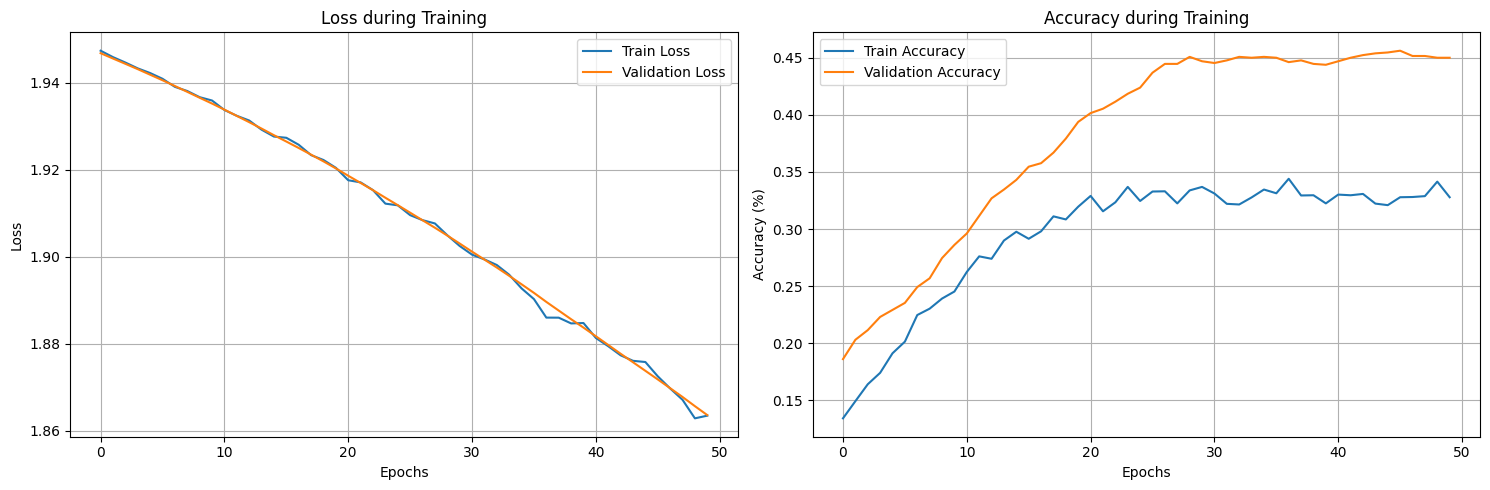

'Accuracy на валидационных данных: 0.45'

In [181]:
model = MLP()
optimizer = optim.ASGD(model.parameters(), lr=0.001)
train_model_wine(model, train_loader, test_loader, 50, optimizer=optimizer)
evaluate_model_wine(model, test_loader)

Качество стало еще ниже.

Попробуем изменить размер батча

In [182]:
class MLP(nn.Module):
    def __init__(self, in_features=11, num_classes=7):
        super(MLP, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True)
        )

        self.net2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.net1(x)
        x = self.net2(x)

        return x

In [188]:
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

 20%|██        | 10/50 [00:08<00:39,  1.02it/s]

Epoch 10/50 | Train Loss: 1.6089 | Val Loss: 1.6250 | Train Acc: 0.55 | Val Acc: 0.54 | 


 40%|████      | 20/50 [00:16<00:24,  1.24it/s]

Epoch 20/50 | Train Loss: 1.5983 | Val Loss: 1.6293 | Train Acc: 0.57 | Val Acc: 0.54 | 


 60%|██████    | 30/50 [00:25<00:16,  1.23it/s]

Epoch 30/50 | Train Loss: 1.5932 | Val Loss: 1.6369 | Train Acc: 0.57 | Val Acc: 0.53 | 


 80%|████████  | 40/50 [00:35<00:09,  1.02it/s]

Epoch 40/50 | Train Loss: 1.5869 | Val Loss: 1.6194 | Train Acc: 0.58 | Val Acc: 0.55 | 


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]

Epoch 50/50 | Train Loss: 1.5786 | Val Loss: 1.6185 | Train Acc: 0.59 | Val Acc: 0.55 | 


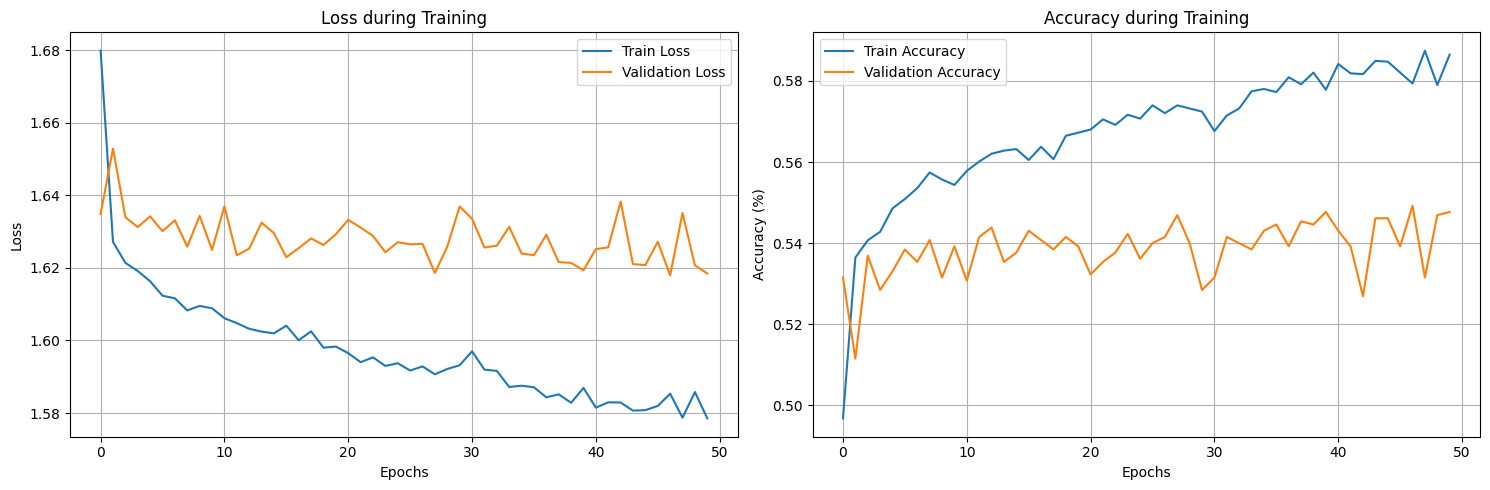

'Accuracy на валидационных данных: 0.55'

In [189]:
model = MLP()
train_model_wine(model, train_loader, test_loader, 50)
evaluate_model_wine(model, test_loader)

Accuracy при размере батча 16 почти такая же как и при той же модели при размере батча 64. Также я пробовала размер батча 32, ситуация аналогичная.

В результате проведенных экспериментов лучшим вариантом оказалась модель с 4 линейными слоями и функциями активации ReLU, оптимайзером AdamW с learning_rate = 0.001, лосс - кросс-энтропия, размер батча = 64.

Предскажем значения из валидационной выборки еще раз и посмотрим, какие классы модель различает хорошо, какие плохо, а также построим confusion matrix.

In [273]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [274]:
class MLP(nn.Module):
    def __init__(self, in_features=11, num_classes=7):
        super(MLP, self).__init__()

        self.net1 = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 64),
            nn.ReLU(inplace=True)
        )

        self.net2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.net1(x)
        x = self.net2(x)

        return x

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 10/50 [00:02<00:10,  3.92it/s]

Epoch 10/50 | Train Loss: 1.6058 | Val Loss: 1.6275 | Train Acc: 0.56 | Val Acc: 0.53 | 


 40%|████      | 20/50 [00:05<00:10,  2.77it/s]

Epoch 20/50 | Train Loss: 1.5970 | Val Loss: 1.6207 | Train Acc: 0.57 | Val Acc: 0.54 | 


 60%|██████    | 30/50 [00:09<00:05,  3.41it/s]

Epoch 30/50 | Train Loss: 1.5868 | Val Loss: 1.6248 | Train Acc: 0.58 | Val Acc: 0.53 | 


 80%|████████  | 40/50 [00:11<00:02,  3.90it/s]

Epoch 40/50 | Train Loss: 1.5791 | Val Loss: 1.6120 | Train Acc: 0.59 | Val Acc: 0.55 | 


100%|██████████| 50/50 [00:14<00:00,  3.53it/s]

Epoch 50/50 | Train Loss: 1.5768 | Val Loss: 1.6119 | Train Acc: 0.59 | Val Acc: 0.55 | 


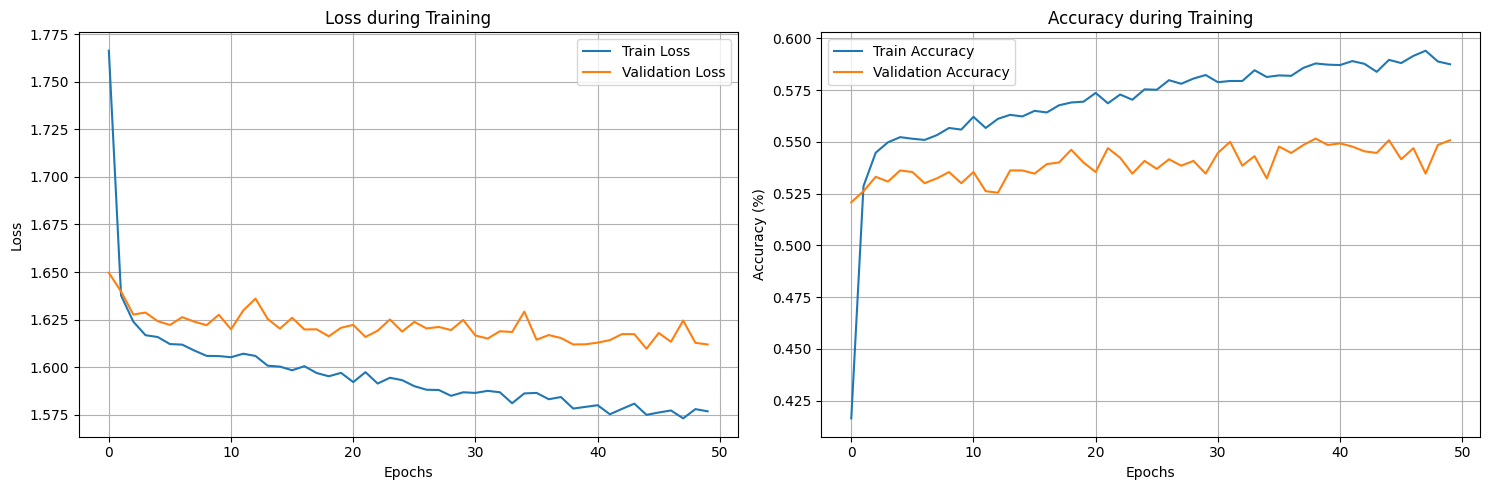

In [275]:
model = MLP()
train_model_wine(model, train_loader, test_loader, 50)

In [276]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

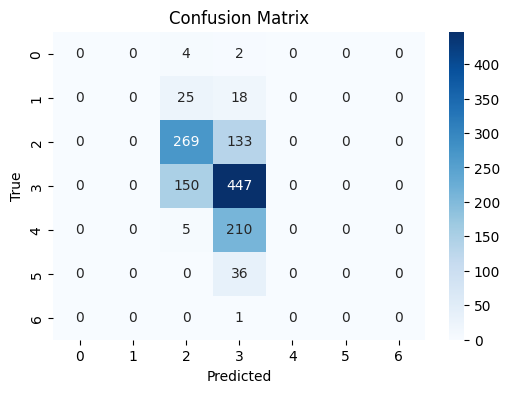

In [277]:
model.eval()
correct_val = 0
total_val = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in test_loader:
        target = target.long()

        if target.dim() > 1:
            target = target.squeeze()

        target = target-3

        output = model(data)
        _, predicted = torch.max(output.data, 1)

        y_pred.extend(predicted)
        y_true.extend(target)

        total_val += target.size(0)
        correct_val += (predicted == target).sum().item()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

val_accuracy = correct_val / total_val

In [278]:
print(f"accuracy: {val_accuracy}")

accuracy: 0.5507692307692308


Вывод: Модель в основном предсказывает классы 2 и 3 (в датасете это 5 и 6), почти полностью игнорируя остальные.
Это возможно из-за несбалансированности данных, недостаточной обобщающей способности модели.

In [279]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00        43
           2       0.59      0.67      0.63       402
           3       0.53      0.75      0.62       597
           4       0.00      0.00      0.00       215
           5       0.00      0.00      0.00        36
           6       0.00      0.00      0.00         1

    accuracy                           0.55      1300
   macro avg       0.16      0.20      0.18      1300
weighted avg       0.43      0.55      0.48      1300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


В среднем модель правильно предсказывает 55% объектов, но с учётом того, что классы 2 и 3 составляют бОльшую часть датасета, а остальные классы почти не предсказываются. Значения precision и recall на классах 2 и 3 (в датасете это 5 и 6) также довольно невысокие

# Задание 3

3.1  Используя только numpy, реализуйте весь функционал для построение и обучения MLP с произвольным количеством скрытых слоев (линейный слой, ф. активации, классификационный лосс и оптимайзер).

3.2 Для реализованного функционала напишите тесты, чтобы forward и backward совпадал с реализациями на torch.

3.3  Натренируйте нейронную сеть на реализованном функционале на данных из Части 2 и с теми же параметрами, что ваша лучшая модель, визуализируйте после каждой эпохи предсказания и сравните результаты вашей и torch реализации.


Напишем классы для линейного слоя (с инициализацией весов как в pytorch), функций активации, оптимайзера AdamW и лосс-функции CrossEntropyLoss

In [280]:
class LinearLayer:
    def __init__(self, input_dim, output_dim):
        # kaiming initialization: uniform(-1/sqrt(in_features), 1/sqrt(in_features))
        limit = 1.0 / np.sqrt(input_dim)
        self.W = np.random.uniform(-limit, limit, (input_dim, output_dim))
        self.b = np.random.uniform(-limit, limit, (1, output_dim))
        self.dW = None
        self.db = None
        self.input = None

    def forward(self, x):
        self.input = x
        return x @ self.W + self.b

    def backward(self, dout):
        self.dW = self.input.T @ dout
        self.db = np.sum(dout, axis=0, keepdims=True)
        return dout @ self.W.T

class ReLU:
    def __init__(self):
        self.input = None

    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, dout):
        return dout * (self.input > 0)

class Softmax:
    def __init__(self):
        self.output = None

    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, dout):
        return dout

class AdamW:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        self.parameters = parameters
        self.m = [{'W': np.zeros_like(p.W), 'b': np.zeros_like(p.b)} for p in parameters]
        self.v = [{'W': np.zeros_like(p.W), 'b': np.zeros_like(p.b)} for p in parameters]
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.parameters):
            param.W -= self.lr * self.weight_decay * param.W

            self.m[i]['W'] = self.beta1 * self.m[i]['W'] + (1 - self.beta1) * param.dW
            self.v[i]['W'] = self.beta2 * self.v[i]['W'] + (1 - self.beta2) * (param.dW ** 2)

            m_hat_w = self.m[i]['W'] / (1 - self.beta1 ** self.t)
            v_hat_w = self.v[i]['W'] / (1 - self.beta2 ** self.t)

            param.W -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.eps)

            self.m[i]['b'] = self.beta1 * self.m[i]['b'] + (1 - self.beta1) * param.db
            self.v[i]['b'] = self.beta2 * self.v[i]['b'] + (1 - self.beta2) * (param.db ** 2)

            m_hat_b = self.m[i]['b'] / (1 - self.beta1 ** self.t)
            v_hat_b = self.v[i]['b'] / (1 - self.beta2 ** self.t)

            param.b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.eps)

class CrossEntropyLoss:
    def __init__(self):
        self.logits = None
        self.true = None
        self.pred = None

    def forward(self, logits, true):
        self.logits = logits
        self.true = true

        logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(logits)
        self.pred = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        self.pred = np.clip(self.pred, 1e-12, 1.0 - 1e-12)

        if true.ndim == 1:
            log_likelihood = -np.log(self.pred[np.arange(len(true)), true])
            loss = np.mean(log_likelihood)
        else:
            log_likelihood = -np.sum(true * np.log(self.pred), axis=1)
            loss = np.mean(log_likelihood)

        return loss

    def backward(self):
        batch_size = len(self.true)

        if self.true.ndim == 1:
            dout = self.pred.copy()
            dout[np.arange(batch_size), self.true] -= 1
            dout /= batch_size
        else:
            dout = (self.pred - self.true) / batch_size

        return dout

Напишем класс для MLP на numpy

In [281]:
class MLP:
    def __init__(self, layer_dims):
        self.layers = []
        self.linear_layers = []

        for i in range(len(layer_dims) - 1):
            linear = LinearLayer(layer_dims[i], layer_dims[i+1])
            self.linear_layers.append(linear)
            self.layers.append(linear)

            if i < len(layer_dims) - 2:
                self.layers.append(ReLU())

        self.criterion = CrossEntropyLoss()

    def forward(self, x, return_logits=False):
        for layer in self.layers:
            x = layer.forward(x)

        if return_logits:
            return x
        else:
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def train_step(self, x, y, optimizer):
        logits = self.forward(x, return_logits=True)
        loss = self.criterion.forward(logits, y)

        dout = self.criterion.backward()
        self.backward(dout)

        optimizer.step()

        return loss, logits

    def predict(self, x):
        pred_probs = self.forward(x, return_logits=False)
        return np.argmax(pred_probs, axis=1)

    def evaluate(self, x, y):
        logits = self.forward(x, return_logits=True)
        loss = self.criterion.forward(logits, y)
        pred_probs = self.forward(x, return_logits=False)
        pred_classes = np.argmax(pred_probs, axis=1)
        acc = np.mean(pred_classes == y)
        return loss, acc

In [282]:
class TorchMLP(nn.Module):
    def __init__(self, layer_dims):
        super(TorchMLP, self).__init__()
        layers = []
        for i in range(len(layer_dims) - 1):
            layers.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
            if i < len(layer_dims) - 2:
                layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            limit = 1.0 / np.sqrt(module.in_features)
            nn.init.uniform_(module.weight, -limit, limit)
            nn.init.uniform_(module.bias, -limit, limit)

    def forward(self, x):
        return self.network(x)

def train_torch_mlp(X_train, y_train, X_test, y_test, layer_dims, epochs=50, batch_size=32, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TorchMLP(layer_dims).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)

    X_train_torch = torch.FloatTensor(X_train).to(device)
    y_train_torch = torch.LongTensor(y_train).to(device)
    X_test_torch = torch.FloatTensor(X_test).to(device)
    y_test_torch = torch.LongTensor(y_test).to(device)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0
        batch_count = 0

        indices = torch.randperm(len(X_train_torch))
        for i in range(0, len(X_train_torch), batch_size):
            batch_indices = indices[i:i+batch_size]
            x_batch = X_train_torch[batch_indices]
            y_batch = y_train_torch[batch_indices]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            pred = torch.argmax(outputs, dim=1)
            acc = (pred == y_batch).float().mean()

            epoch_train_loss += loss.item()
            epoch_train_acc += acc.item()
            batch_count += 1

        epoch_train_loss /= batch_count
        epoch_train_acc /= batch_count

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_torch)
            test_loss = criterion(test_outputs, y_test_torch).item()
            test_pred = torch.argmax(test_outputs, dim=1)
            test_acc = (test_pred == y_test_torch).float().mean().item()

        train_losses.append(epoch_train_loss)
        test_losses.append(test_loss)
        train_accs.append(epoch_train_acc)
        test_accs.append(test_acc)

        if (epoch + 1) % 10 == 0:
            print(f"PyTorch Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
                  f"Test Acc: {test_acc:.4f}")

    return train_losses, test_losses, train_accs, test_accs, model

Напишем классы для тестов forward и backward на слоях и функциях активации

In [283]:
def test_linear_layer():
    print("Testing linear layer")
    np.random.seed(42)
    torch.manual_seed(42)

    batch_size, input_dim, output_dim = 4, 3, 2
    x_np = np.random.randn(batch_size, input_dim).astype(np.float32)

    np_linear = LinearLayer(input_dim, output_dim)
    np_output = our_linear.forward(x_np)

    torch_linear = nn.Linear(input_dim, output_dim, bias=True)

    with torch.no_grad():
        torch_linear.weight.copy_(torch.tensor(our_linear.W.T))
        torch_linear.bias.copy_(torch.tensor(our_linear.b[0]))

    x_torch = torch.tensor(x_np, requires_grad=True)
    torch_output = torch_linear(x_torch)

    forward_diff = np.max(np.abs(np_output - torch_output.detach().numpy()))
    print(f"Linear layer forward diff: {forward_diff:.6f}")

    dout_np = np.random.randn(batch_size, output_dim).astype(np.float32)
    np_dinput = np_linear.backward(dout_np)

    torch_output.backward(torch.tensor(dout_np))
    torch_dinput = x_torch.grad.numpy()

    backward_diff = np.max(np.abs(np_dinput - torch_dinput))
    print(f"Linear layer backward diff: {backward_diff:.6f}")

    # Testing gradient calculation
    np_dW = np_linear.dW
    torch_dW = torch_linear.weight.grad.numpy().T
    dW_diff = np.max(np.abs(np_dW - torch_dW))
    print(f"Linear layer dW diff: {dW_diff:.6f}")

    np_db = np_linear.db
    torch_db = torch_linear.bias.grad.numpy().reshape(1, -1)
    db_diff = np.max(np.abs(np_db - torch_db))
    print(f"Linear layer db diff: {db_diff:.6f}")

    return forward_diff < 1e-5 and backward_diff < 1e-5

def test_relu():
    print("\nTesting reLU activation")
    np.random.seed(42)
    torch.manual_seed(42)

    x_np = np.random.randn(5, 4).astype(np.float32)

    np_relu = ReLU()
    np_output = np_relu.forward(x_np)

    torch_relu = nn.ReLU()
    x_torch = torch.tensor(x_np, requires_grad=True)
    torch_output = torch_relu(x_torch)

    forward_diff = np.max(np.abs(np_output - torch_output.detach().numpy()))
    print(f"ReLU forward diff: {forward_diff:.6f}")

    dout_np = np.random.randn(5, 4).astype(np.float32)
    np_dinput = np_relu.backward(dout_np)

    torch_output.backward(torch.tensor(dout_np))
    torch_dinput = x_torch.grad.numpy()

    backward_diff = np.max(np.abs(np_dinput - torch_dinput))
    print(f"ReLU backward diff: {backward_diff:.6f}")

    return forward_diff < 1e-5 and backward_diff < 1e-5

def test_softmax():
    print("\nTesting softmax activation")
    np.random.seed(42)
    torch.manual_seed(42)

    x_np = np.random.randn(3, 5).astype(np.float32)

    np_softmax = Softmax()
    np_output = np_softmax.forward(x_np)

    x_torch = torch.tensor(x_np, requires_grad=True)
    torch_output = torch.softmax(x_torch, dim=1)

    forward_diff = np.max(np.abs(np_output - torch_output.detach().numpy()))
    print(f"Softmax forward diff: {forward_diff:.6f}")

    return forward_diff < 1e-5

def test_cross_entropy():
    print("\nTesting cross entropy loss")
    np.random.seed(42)
    torch.manual_seed(42)

    batch_size, num_classes = 4, 3
    logits_np = np.random.randn(batch_size, num_classes).astype(np.float32)
    target_np = np.random.randint(0, num_classes, (batch_size,))

    np_ce = CrossEntropyLoss()
    np_loss = np_ce.forward(logits_np, target_np)
    np_dout = np_ce.backward()

    logits_torch = torch.tensor(logits_np, requires_grad=True)
    target_torch = torch.tensor(target_np)
    torch_ce = nn.CrossEntropyLoss()
    torch_loss = torch_ce(logits_torch, target_torch)
    torch_loss.backward()

    loss_diff = np.abs(np_loss - torch_loss.item())
    print(f"Cross entropy loss diff: {loss_diff:.6f}")

    torch_dout = logits_torch.grad.numpy()
    dout_diff = np.max(np.abs(np_dout - torch_dout))
    print(f"Cross entropy gradient diff: {dout_diff:.6f}")

    print(f"Numpy loss: {np_loss:.6f}, Torch loss: {torch_loss.item():.6f}")
    print(f"Max gradient diff: {dout_diff:.6f}")

    return loss_diff < 1e-5 and dout_diff < 1e-5

def test_mlp_forward():
    print("\nTesting MLP forward pass")
    np.random.seed(42)
    torch.manual_seed(42)

    batch_size, input_dim = 8, 10
    x_np = np.random.randn(batch_size, input_dim).astype(np.float32)
    layer_dims = [10, 5, 3]

    np_mlp = MLP(layer_dims)
    np_output = np_mlp.forward(x_np)

    class TorchMLP(nn.Module):
        def __init__(self, layer_dims):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Linear(layer_dims[0], layer_dims[1]),
                nn.ReLU(),
                nn.Linear(layer_dims[1], layer_dims[2]),
            )

        def forward(self, x):
            return self.layers(x)

    torch_mlp = TorchMLP(layer_dims)

    with torch.no_grad():
        # First linear layer
        torch_mlp.layers[0].weight.copy_(torch.tensor(np_mlp.linear_layers[0].W.T))
        torch_mlp.layers[0].bias.copy_(torch.tensor(np_mlp.linear_layers[0].b[0]))
        # Second linear layer
        torch_mlp.layers[2].weight.copy_(torch.tensor(np_mlp.linear_layers[1].W.T))
        torch_mlp.layers[2].bias.copy_(torch.tensor(np_mlp.linear_layers[1].b[0]))

    x_torch = torch.tensor(x_np)
    torch_output = torch_mlp(x_torch)
    torch_output_softmax = torch.softmax(torch_output, dim=1)


    output_diff = np.max(np.abs(np_output - torch_output_softmax.detach().numpy()))
    print(f"MLP forward diff: {output_diff:.6f}")

    return output_diff < 1e-5

def run_all_tests():
    print("=" * 60)
    print("Detailed Layer Tests")
    print("=" * 60)

    tests = [
        test_linear_layer,
        test_relu,
        test_softmax,
        test_cross_entropy,
        test_mlp_forward
    ]

    all_passed = True
    for test in tests:
        try:
            passed = test()
            all_passed = all_passed and passed
            status = "PASSED" if passed else "FAILED"
            print(f"Test {test.__name__}: {status}\n")
        except Exception as e:
            print(f"Test {test.__name__}: ERROR - {e}\n")
            all_passed = False

    print("=" * 60)
    print(f"Overall test result: {'PASSED' if all_passed else 'FAILED'}")
    print("=" * 60)

    return all_passed


In [293]:
def load_and_preprocess_data():
    wine_quality = fetch_ucirepo(id=186)
    X = wine_quality.data.features
    y = wine_quality.data.targets

    X = X.fillna(X.mean())
    X = X.values
    y = y.values.ravel()
    y = y - 3

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def compare_implementations():
    X_train, X_test, y_train, y_test = load_and_preprocess_data()

    input_dim = X_train.shape[1]
    hidden_dims = [32, 64, 128]
    output_dim = 7
    layer_dims = [input_dim] + hidden_dims + [output_dim]

    print(f"Model architecture: {layer_dims}")

    # random seeds
    np.random.seed(42)
    torch.manual_seed(42)

    # Train numpy implementation
    print("\n" + "="*60)
    print("Training numpy implementation")
    print("="*60)

    np_mlp = MLP(layer_dims)
    np_optimizer = AdamW(np_mlp.linear_layers, lr=0.001, weight_decay=0.01)

    np_train_losses = []
    np_test_losses = []
    np_train_accs = []
    np_test_accs = []

    epochs = 50
    batch_size = 64

    for epoch in range(epochs):
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        epoch_train_loss = 0
        epoch_train_acc = 0
        batch_count = 0

        for i in range(0, len(X_train), batch_size):
            batch_end = min(i + batch_size, len(X_train))
            x_batch = X_train_shuffled[i:batch_end]
            y_batch = y_train_shuffled[i:batch_end]

            loss, pred = np_mlp.train_step(x_batch, y_batch, np_optimizer)
            pred_classes = np.argmax(pred, axis=1)
            acc = np.mean(pred_classes == y_batch)

            epoch_train_loss += loss
            epoch_train_acc += acc
            batch_count += 1

        epoch_train_loss /= batch_count
        epoch_train_acc /= batch_count

        test_loss, test_acc = np_mlp.evaluate(X_test, y_test)

        np_train_losses.append(epoch_train_loss)
        np_test_losses.append(test_loss)
        np_train_accs.append(epoch_train_acc)
        np_test_accs.append(test_acc)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: train loss: {epoch_train_loss:.4f}, "
                  f"Test loss: {test_loss:.4f}, train acc: {epoch_train_acc:.4f}, "
                  f"Test acc: {test_acc:.4f}")

    # Train PyTorch implementation
    print("\n" + "="*60)
    print("Training Pytorch implementation")
    print("="*60)

    torch_train_losses, torch_test_losses, torch_train_accs, torch_test_accs, torch_model = train_torch_mlp(
        X_train, y_train, X_test, y_test, layer_dims, epochs=epochs, lr=0.001
    )

    # results
    print("\n" + "="*60)
    print("Comparison results")
    print("="*60)

    print(f"\nFinal numpy implementation:")
    print(f"Train loss: {np_train_losses[-1]:.4f}, Test loss: {np_test_losses[-1]:.4f}")
    print(f"Train acc: {np_train_accs[-1]:.4f}, Test acc: {np_test_accs[-1]:.4f}")

    print(f"\nFinal Pytorch implementation:")
    print(f"Train loss: {torch_train_losses[-1]:.4f}, Test loss: {torch_test_losses[-1]:.4f}")
    print(f"Train acc: {torch_train_accs[-1]:.4f}, Test acc: {torch_test_accs[-1]:.4f}")

    plot_comparison(np_train_losses, np_test_losses, np_train_accs, np_test_accs,
                   torch_train_losses, torch_test_losses, torch_train_accs, torch_test_accs)

def plot_comparison(np_train_losses, np_test_losses, np_train_accs, np_test_accs,
                   torch_train_losses, torch_test_losses, torch_train_accs, torch_test_accs):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss comparison
    epochs = range(1, len(np_train_losses) + 1)

    ax1.plot(epochs, np_train_losses, 'b-', label='numpy train loss', alpha=0.7)
    ax1.plot(epochs, torch_train_losses, 'b--', label='Pytorch train loss', alpha=0.7)
    ax1.plot(epochs, np_test_losses, 'r-', label='Numpy test loss', alpha=0.7)
    ax1.plot(epochs, torch_test_losses, 'r--', label='Pytorch test loss', alpha=0.7)
    ax1.set_title('Loss comparison: numpy vs pytorch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy comparison
    ax2.plot(epochs, np_train_accs, 'g-', label='numpy train acc', alpha=0.7)
    ax2.plot(epochs, torch_train_accs, 'g--', label='Pytorch train acc', alpha=0.7)
    ax2.plot(epochs, np_test_accs, 'orange', label='numpy test acc', alpha=0.7)
    ax2.plot(epochs, torch_test_accs, 'orange', linestyle='--', label='Pytorch test acc', alpha=0.7)
    ax2.set_title('Accuracy comparison: numpy vs pytorch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Difference in losses
    np_loss_diff = np.array(np_train_losses) - np.array(torch_train_losses)
    ax3.plot(epochs, np_loss_diff, 'purple', label='Train loss difference (numpy - pytorch)')
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax3.set_title('Difference in train losses')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss difference')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Difference in accuracies
    np_acc_diff = np.array(np_train_accs) - np.array(torch_train_accs)
    ax4.plot(epochs, np_acc_diff, 'brown', label='Train acc difference (numpy - pytorch)')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax4.set_title('Difference in train accuracies')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy difference')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nStatistical Comparison:")
    print(f"Mean numpy train loss: {np.mean(np_train_losses):.4f} ± {np.std(np_train_losses):.4f}")
    print(f"Mean Pytorch train loss: {np.mean(torch_train_losses):.4f} ± {np.std(torch_train_losses):.4f}")
    print(f"Mean numpy train acc: {np.mean(np_train_accs):.4f} ± {np.std(np_train_accs):.4f}")
    print(f"Mean Pytorch train acc: {np.mean(torch_train_accs):.4f} ± {np.std(torch_train_accs):.4f}")

    loss_close = np.allclose(np_train_losses, torch_train_losses, atol=0.1)
    acc_close = np.allclose(np_train_accs, torch_train_accs, atol=0.05)

    print(f"\nImplementations are similar (loss within 0.1): {loss_close}")
    print(f"Implementations are similar (accuracy within 0.05): {acc_close}")

Применим реализацию MLP на torch и реализацию MLP на numpy к датасету wine quality, проведем тесты на разницу в значениях backward и forward на линейных слоях и функциях активации, также сравним лоссы и accuracy. Параметры такие же, как и в лучшей реализации во 2 задании: размеры скрытых слоев [32, 64, 128], learning_rate = 0.001, optimizer = AdamW, CrossEntropyLoss, batch_size = 64.

Detailed Layer Tests
Testing linear layer
Linear layer forward diff: 0.000000
Linear layer backward diff: 0.000000
Linear layer dW diff: 0.000000
Linear layer db diff: 0.000000
Test test_linear_layer: PASSED


Testing reLU activation
ReLU forward diff: 0.000000
ReLU backward diff: 0.000000
Test test_relu: PASSED


Testing softmax activation
Softmax forward diff: 0.000000
Test test_softmax: PASSED


Testing cross entropy loss
Cross entropy loss diff: 0.000000
Cross entropy gradient diff: 0.000000
Numpy loss: 1.170155, Torch loss: 1.170155
Max gradient diff: 0.000000
Test test_cross_entropy: PASSED


Testing MLP forward pass
MLP forward diff: 0.000000
Test test_mlp_forward: PASSED

Overall test result: PASSED
Model architecture: [11, 32, 64, 128, 7]

Training numpy implementation
Epoch 10: train loss: 0.9967, Test loss: 1.0379, train acc: 0.5746, Test acc: 0.5569
Epoch 20: train loss: 0.9517, Test loss: 1.0262, train acc: 0.5920, Test acc: 0.5654
Epoch 30: train loss: 0.9119, Test loss: 

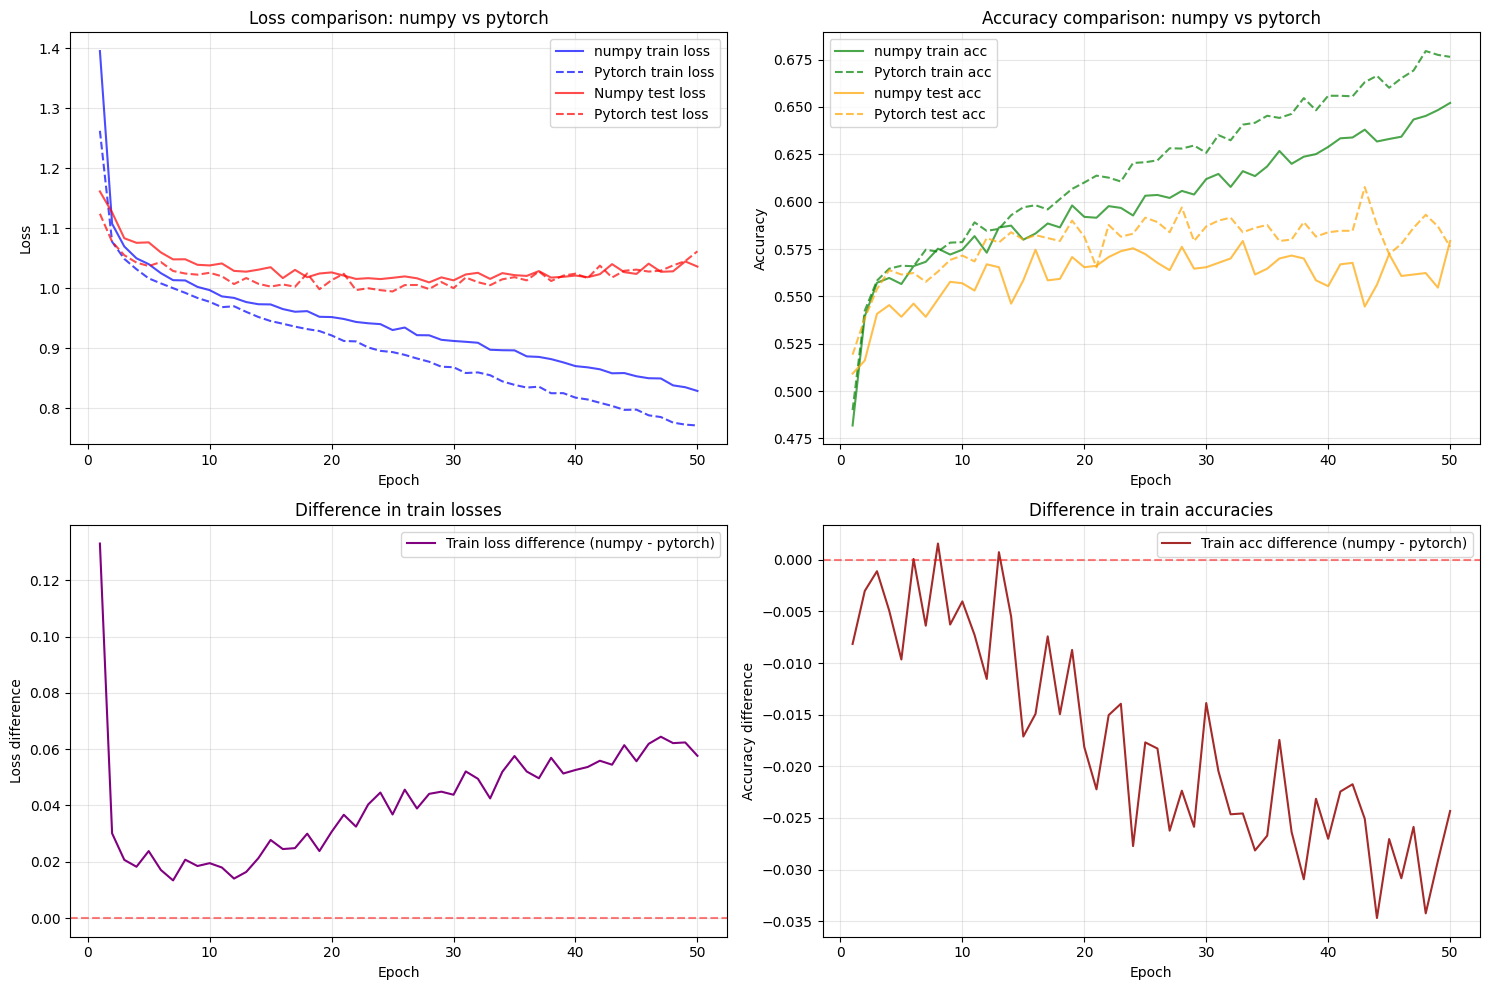


Statistical Comparison:
Mean numpy train loss: 0.9422 ± 0.0915
Mean Pytorch train loss: 0.9011 ± 0.0943
Mean numpy train acc: 0.6001 ± 0.0317
Mean Pytorch train acc: 0.6176 ± 0.0397

Implementations are similar (loss within 0.1): False
Implementations are similar (accuracy within 0.05): True


In [294]:
    run_all_tests()
    compare_implementations()

Итак:

Final numpy implementation:
Train loss: 0.8285, Test loss: 1.0360
Train acc: 0.6521, Test acc: 0.5792

Final Pytorch implementation:
Train loss: 0.7708, Test loss: 1.0615
Train acc: 0.6764, Test acc: 0.5762

Как видно из отчета, разница в accuracy у двух реализаций (на тесте) составляет 0.003

In [286]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
